### Create Synthetic Datasets
---

This notebook is used to generate simple sinusoidal synthetic datasets with a specified numbers of worms, named neurons, and other characteristics of real datasets.

**Last update:** _2 May 2024_

#### Libraries and helper functions
---

In [ ]:
import torch
import pickle
import random
import tiktoken
import numpy as np
import scipy as scp
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

from openai import OpenAI
from omegaconf import OmegaConf
from typing import Protocol, Union
from scipy.integrate import odeint
from transformers import AutoTokenizer
from sklearn.preprocessing import StandardScaler
from datasets import load_dataset as load_hf_dataset
from tokenizers.pre_tokenizers import WhitespaceSplit
from utils import NUM_TOKENS, NEURON_LABELS, init_random_seeds
from preprocess._utils import smooth_data_preprocess, reshape_calcium_data

# Initialize the random seeds
init_random_seeds(42)

##### Helper functions
___

In [ ]:
def plot_neural_signals(data, time_tensor, neuron_idx=None, yax_limit=True, suptitle=None):
    assert isinstance(data, torch.Tensor), "data must be a PyTorch tensor"
    assert isinstance(time_tensor, torch.Tensor), "time_tensor must be a PyTorch tensor"
    assert data.dim() == 2, "data must be a 2D tensor"
    assert isinstance(neuron_idx, (int, list)), "neuron_idx must be an integer or list"

    time_tensor = time_tensor.squeeze()
    assert data.size(0) == time_tensor.size(0), "Number of rows in data and time_tensor must match"

    num_neurons = data.size(1)

    # Randomly select the column indices if not provided
    if isinstance(neuron_idx, int):
        assert neuron_idx <= num_neurons, "neuron_idx cannot exceed the number of neurons"
        column_indices = np.random.choice(num_neurons, neuron_idx, replace=False)
    elif isinstance(neuron_idx, list):
        assert len(neuron_idx) <= num_neurons, "neuron_idx cannot exceed the number of neurons"
        column_indices = np.array(neuron_idx)

    num_columns = len(column_indices)

    # Extract the selected columns from the data tensor
    selected_columns = data[:, column_indices]

    # Define the color palette using scientific colors
    colors = sns.color_palette("bright", num_columns)

    # Plotting subplots vertically
    fig, axs = plt.subplots(num_columns, 1, figsize=(15, num_columns))
    fig.tight_layout(pad=0.0)

    # If num_columns is 1, make ax iterable by wrapping it in a list
    if num_columns == 1:
        axs = [axs]

    # Now your existing loop should work without modification
    for i, ax in enumerate(axs):
        ax.plot(time_tensor, selected_columns[:, i], color=colors[i])
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.yaxis.set_ticks_position("none")
        if yax_limit:
            ax.set_ylim(-1.0, 1.0)
        ax.set_ylabel("{}".format(NEURON_LABELS[column_indices[i]]))

        if i < num_columns - 1:
            ax.set_xticks([])
        else:
            ax.set_xlabel("Time (s)")

    # Add a super title to the figure if provided
    if suptitle is not None:
        fig.suptitle(suptitle, fontsize=16)

    plt.tight_layout(pad=1)

    plt.show()

In [ ]:
def plot_3d_trajectory(X, axis_labels=("Time", "Value", "Z Axis"), title="Trajectory", show=True):
    """
    Plot a trajectory from a dataset, which can be 1D, 2D, or 3D.

    Parameters:
    - X: A 2D numpy array containing the trajectory data.
    - axis_labels: A tuple containing the labels for the axes. Default is ('Time', 'Value', 'Z Axis').
    - title: Title of the plot.
    - show: If True, the plot will be displayed. If False, the plot object will be returned.

    Returns:
    - fig, ax: The figure and axis objects of the plot if show is False.
    """
    max_timesteps = X.shape[0]
    dims = X.shape[1] if len(X.shape) > 1 else 1

    # Create a new figure for the plot
    fig = plt.figure()
    if dims >= 3:
        ax = fig.add_subplot(111, projection="3d")
        plot_dims = 3
    else:
        ax = fig.add_subplot(111)
        plot_dims = dims

    # Create a color map based on the time progression
    norm = plt.Normalize(0, max_timesteps)
    colors = plt.cm.viridis(norm(np.arange(max_timesteps)))

    # Extract coordinates from the data and plot accordingly
    if plot_dims == 1:
        x = np.arange(max_timesteps)
        y = X.flatten()
        z = np.zeros(max_timesteps)
        ax_labels = ("Time", axis_labels[0], "Fixed Z")
        # Plot the 1D trajectory with a color gradient
        for i in range(1, max_timesteps):
            ax.plot(x[i - 1 : i + 1], y[i - 1 : i + 1], color=colors[i], lw=0.5)
        # Mark the start and end of the trajectory
        ax.plot(x[0], y[0], "g*", markersize=8)  # Start with a green star
        ax.plot(x[-1], y[-1], "ro", markersize=7)  # End with a red circle
    elif plot_dims == 2:
        # Pick two random columns to plot
        ind_x, ind_y = np.random.choice(X.shape[1], 2, replace=False)
        x, y = X[:, ind_x], X[:, ind_y]
        z = np.zeros(max_timesteps)
        ax_labels = (axis_labels[0], axis_labels[1], "Fixed Z")
        # Plot the 2D trajectory
        for i in range(1, max_timesteps):
            ax.plot(x[i - 1 : i + 1], y[i - 1 : i + 1], color=colors[i], lw=0.5)
        # Mark the start and end of the trajectory
        ax.plot(x[0], y[0], "g*", markersize=8)  # Start with a green star
        ax.plot(x[-1], y[-1], "ro", markersize=7)  # End with a red circle
    else:  # plot_dims == 3
        ind_x, ind_y, ind_z = np.random.choice(X.shape[1], 3, replace=False)
        x, y, z = X[:, ind_x], X[:, ind_y], X[:, ind_z]
        ax_labels = axis_labels
        # Plot the 3D trajectory
        for i in range(1, max_timesteps):
            ax.plot(
                x[i - 1 : i + 1],
                y[i - 1 : i + 1],
                z[i - 1 : i + 1],
                color=colors[i],
                lw=0.5,
            )
        # Mark the start and end of the trajectory
        ax.plot(x[0], y[0], z[0], "g*", markersize=8)  # Start with a green star
        ax.plot(x[-1], y[-1], z[-1], "ro", markersize=7)  # End with a red circle

    # Set labels for the axes
    ax.set_xlabel(ax_labels[0])
    ax.set_ylabel(ax_labels[1])
    if plot_dims == 3:
        ax.set_zlabel(ax_labels[2])

    # Set title
    ax.set_title(title)

    # Show the plot
    if show:
        plt.show()
    else:
        return fig, ax

In [ ]:
def lorenz(X, t, sigma=10.0, beta=8.0 / 3, rho=28.0):
    """The Lorenz equations."""
    x, y, z = X
    dx_dt = sigma * (y - x)
    dy_dt = x * (rho - z) - y
    dz_dt = x * y - beta * z
    return [dx_dt, dy_dt, dz_dt]

In [ ]:
def van_der_pol_oscillator(X, t, mu=1.0):
    """The Van der Pol oscillator equations."""
    x, y = X
    dx_dt = y
    dy_dt = mu * (1 - x**2) * y - x
    return [dx_dt, dy_dt]

In [ ]:
class SinusoidsOscillator:
    def __init__(self, sum_freqs=0, random=True):
        self.eps = np.finfo(float).eps
        # the number of frequencies sum composing a frequency fingerprint
        self.sum_freqs = sum_freqs
        self.random = random
        # create frequencies and phases
        if self.random:  # use random frequencies
            self.freqs = np.round(self.eps + np.random.random(self.sum_freqs) / 10, 4)
        else:  # use deterministic frequencies
            self.freqs = np.round(
                np.arange(1 / (2 * self.sum_freqs + self.eps), self.sum_freqs)
                / (10 * self.sum_freqs),
                4,
            )
        # always use random phases
        self.phases = np.random.random(self.sum_freqs) * 2 * np.pi

    def __call__(self, Y, t):
        y = Y
        # the leak term -y ensures convergence to a fixed point if no external input is provided
        dy_dt = -y + sum(np.cos(2 * np.pi * f * t + p) for f, p in zip(self.freqs, self.phases))
        return dy_dt


# create an instance of a SinusoidsOscillator dynamical system
sinusoids_oscillator = SinusoidsOscillator()

In [ ]:
def save_synthetic_dataset(file_name, dataset):
    with open(file_name, "wb") as f:
        pickle.dump(dataset, f)

In [ ]:
def calculate_spectral_radius(matrix):
    eigenvalues = np.linalg.eigvals(matrix).real
    spectral_radius = max(abs(eigenvalues))
    return spectral_radius

In [ ]:
def adjust_matrix_to_edge_of_chaos(matrix, target_radius=1.0):
    # Calculate the current spectral radius
    current_radius = calculate_spectral_radius(matrix)

    # Calculate the gain needed to adjust the spectral radius to the target
    gain = target_radius / current_radius

    # Scale the matrix by the gain
    adjusted_matrix = matrix * gain

    return adjusted_matrix, gain

In [ ]:
def pre_tokenize_and_chunk(texts, max_length=510):
    """
    Pre-tokenize and chunk the text into segments of a specified maximum length.

    Args:
        texts (list of str): List of strings.
        max_length (int): Maximum length of each chunk.

    Returns:
        list: A list of text chunks.
    """
    joined_text = " ".join(texts)
    pre_tokenizer = WhitespaceSplit()
    pre_tokens = pre_tokenizer.pre_tokenize_str(joined_text)

    chunks = []
    current_chunk = ""
    for token, (start, end) in pre_tokens:
        if len(current_chunk) + len(token) + 1 > max_length:
            chunks.append(current_chunk.strip())
            current_chunk = token
        else:
            current_chunk += " " + token if current_chunk else token
    if current_chunk:
        chunks.append(current_chunk.strip())

    return chunks

In [ ]:
def tokenize_and_chunk(texts, tokenizer, max_length=512):
    """
    Tokenize and chunk texts.

    Args:
        texts (list of str): Input texts.
        tokenizer: Tokenizer instance.
        max_length (int): Max length (in chars) string to tokenize.

    Returns:
        dict: Dictionary containing text and token ids.
    """
    text = []
    input_ids = []
    chunks = pre_tokenize_and_chunk(texts, max_length - 2)  # adjust for special tokens
    for chunk in chunks:
        text.append(chunk)  # each chunk is a string shorter than max_length characters
        tokens = tokenizer.encode(chunk)  # returns a list of integers
        input_ids.append(tokens)
    text_and_tokens = {"text": text, "input_ids": input_ids}
    return text_and_tokens

In [ ]:
def get_embedding(text, model="text-embedding-3-small", dimensions=NUM_TOKENS):
    """
    We can ue OpenAI's Embeddings API to get embeddings directly from text to embeddings.
    This is shorter than tokenizing the text first followed by using an embedding layer.
    The OpenAI Embeddings model directly converts an entire string (i.e. chunk of text)
    into a single embedding vector.
    """
    client = OpenAI()
    if isinstance(text, list):
        assert isinstance(text[0], str), "List of strings expected."
        text = [string.replace("\n", " ") for string in text]
        input = text
    else:
        assert isinstance(text, str), "String expected."
        text = text.replace("\n", " ")
        input = [text]
    data = client.embeddings.create(input=input, model=model, dimensions=dimensions).data
    result = [
        np.array(d.embedding) for d in data
    ]  # list of array; each array is an embedding vector
    return result

#### Define some tokenizers to experiment with

In [ ]:
HF_TOKENIZER = AutoTokenizer.from_pretrained("google/byt5-large")
BASE_TOKENIZER = tiktoken.get_encoding("cl100k_base")
GPT4_TOKENIZER = tiktoken.encoding_for_model("gpt-4")


class TokenizerProtocol(Protocol):
    """
    We define a simple common interface that all
    tokenizers to be used in our code must implement.
    """

    def encode(self, text: str) -> dict: ...


# # # ##### DEBUG: Going straight from text chunks to embeddings using OpenAI's Embeddings model #####
# tokenizer = BASE_TOKENIZER
# text_dataset = load_hf_dataset("wikitext", "wikitext-2-v1")
# text_dataset = tokenize_and_chunk(text_dataset["train"]["text"], tokenizer)
# chunks = pre_tokenize_and_chunk(text_dataset["text"], max_length=64)
# embdeddings = get_embedding(chunks[:10]) # restrict to 10 API calls
# print()
# print(f"embeddings array: {np.array(embdeddings).shape}\n")
# print(f"embeddings tensor: {torch.tensor(embdeddings).shape}\n")
# # # ##################################################################################################################

#### Get default parameter values from configs and utils

In [ ]:
config = OmegaConf.load("../configs/submodule/preprocess.yaml")
DELTA_T = config.preprocess.resample_dt

#### Wikitext dataset

In [ ]:
def create_synthetic_dataset_wikitext(
    max_timesteps: int = 1000,
    num_worms: int = 1,
    num_signals: int = 302,
    num_named_neurons: Union[None, int] = None,
    use_openai: bool = False,
    tokenizer: Union[None, TokenizerProtocol] = None,
    delta_seconds: float = DELTA_T,
    smooth_method: Union[None, str] = "ES",
    transform: Union[None, callable] = StandardScaler(),
    dataset_name: str = "Wikitext0000",
):
    """
    TODO: Write a comprehensive docstring.
    The main idea here is to treat the embeddings of a 1D sequence of tokens
    as if it was a multi-dimensional time series of neural activity.
    """
    eps = np.finfo(float).eps
    dataset = {}
    # Determine the timepoints for sampling the data (i.e. "measurement" times)
    time_in_seconds = delta_seconds * np.arange(max_timesteps).reshape(-1, 1)  # column vector
    # Calculate number of named and unknown neurons
    if num_named_neurons is None or num_named_neurons > num_signals:  # default to all neurons
        num_named_neurons = num_signals
    elif num_named_neurons < 0:  # default to no neurons
        num_named_neurons = 0
    num_unknown_neurons = num_signals - num_named_neurons
    # Initializae the tokenizer and set vocab_size attribute
    if tokenizer is None:
        tokenizer = BASE_TOKENIZER
    if isinstance(tokenizer, tiktoken.core.Encoding):
        tokenizer.vocab_size = tokenizer.n_vocab
    # Load the WikiText dataset
    text_dataset = load_hf_dataset("wikitext", "wikitext-2-v1")
    # Process and tokenize just the train split
    text_dataset = tokenize_and_chunk(text_dataset["train"]["text"], tokenizer, max_length=256)
    # Create a fixed embedding map from tokens to embedding vectors
    embed_dim = num_signals
    # Random initialization of embeddings using normal distribution
    embedding_weights = torch.randn(tokenizer.vocab_size, embed_dim)
    torch.nn.init.normal_(embedding_weights, mean=0.0, std=1.0)
    num_tokens = embedding_weights.shape[0]
    assert isinstance(embedding_weights, torch.Tensor) and embedding_weights.shape == (
        num_tokens,
        embed_dim,
    ), f"embedding_weight must be a PyTorch tensor of shape ({num_tokens}, {embed_dim})"
    # Create fixed embedding layer / table
    embedding = torch.nn.Embedding(
        num_embeddings=num_tokens,
        embedding_dim=embed_dim,
        dtype=torch.half,
        _weight=embedding_weights,
        _freeze=True,
    )
    # Create combined dataset of the embedded token sequences from the train split
    if use_openai:
        text_chunks = pre_tokenize_and_chunk(text_dataset["text"], max_length=64)
        max_size = 1 + max_timesteps * num_worms  # restricts the number of API calls
        combo_embd_chunks = get_embedding(text_chunks[:max_size], dimensions=embed_dim)
    else:
        combo_embd_chunks = [
            embedding(torch.LongTensor(sequence)).detach().numpy()
            for sequence in text_dataset["input_ids"]
        ]
    # Create data for as many worms as possible if not enough data
    worm_idx = 0
    calcium_data = []  # will be shaped (time, neurons)
    total_time = 0
    # Keep growing a sequence of embeddings until we reach the maximum timesteps
    for chunk in combo_embd_chunks:
        # Reshape to a row vector if necessary
        if chunk.ndim == 1:
            chunk = chunk.reshape(1, -1)
        # If we have enough worms break out of the loop
        if worm_idx >= num_worms:
            break
        # Otherwise continue extending the calcium data
        calcium_data.append(chunk)
        total_time += chunk.shape[0]
        # Preprocess calcium data once enough timesteps have been created
        if total_time >= max_timesteps:
            calcium_data = np.vstack(calcium_data)[:max_timesteps]
            # Choose a random subset of neurons to record / observe / measure
            named_neuron_indices = random.sample(
                range(num_signals), num_named_neurons
            )  # without replacement
            named_neurons = set(NEURON_LABELS[i] for i in named_neuron_indices)
            # Create neuron to idx mapping and vice versa
            neuron_to_idx = {
                (neuron) if neuron in named_neurons else str(idx): idx
                for idx, neuron in enumerate(NEURON_LABELS)
            }
            idx_to_neuron = {idx: neuron for neuron, idx in neuron_to_idx.items()}
            # Zero out non-recorded / "unobserved" neurons
            unknown_neuron_indices = np.array(
                [idx for idx in range(num_signals) if idx not in named_neuron_indices]
            )
            calcium_data[:, unknown_neuron_indices] *= 0.0
            # Normalize data
            if transform:
                calcium_data = transform.fit_transform(calcium_data)
            # Calculate residuals
            dt = np.diff(time_in_seconds, axis=0, prepend=0.0)
            resample_dt = np.median(dt[1:]).item()
            residual_calcium = np.gradient(calcium_data, time_in_seconds.squeeze(), axis=0)
            # Smooth the data
            smooth_calcium_data = smooth_data_preprocess(
                calcium_data,
                time_in_seconds,
                smooth_method,
                **dict(alpha=0.5, window_size=15, sigma=5),
            )
            smooth_residual_calcium = smooth_data_preprocess(
                residual_calcium,
                time_in_seconds,
                smooth_method,
                **dict(alpha=0.5, window_size=15, sigma=5),
            )
            # Initialize worm data
            worm = f"worm{worm_idx}"
            worm_data = dict()
            # Save the data
            worm_data["worm"] = worm
            worm_data["source_dataset"] = dataset_name
            worm_data["smooth_method"] = smooth_method
            worm_data["calcium_data"] = calcium_data
            worm_data["smooth_calcium_data"] = smooth_calcium_data
            worm_data["residual_calcium"] = residual_calcium
            worm_data["smooth_residual_calcium"] = smooth_residual_calcium
            worm_data["max_timesteps"] = max_timesteps
            worm_data["time_in_seconds"] = time_in_seconds
            worm_data["dt"] = dt
            worm_data["median_dt"] = resample_dt
            worm_data["neuron_to_idx"] = neuron_to_idx
            worm_data["idx_to_neuron"] = idx_to_neuron
            worm_data["num_neurons"] = num_signals
            worm_data["num_named_neurons"] = num_named_neurons
            worm_data["num_unknown_neurons"] = num_unknown_neurons
            worm_data["extra_info"] = {
                "embedding_weights": embedding_weights,
                "num_tokens": num_tokens,
                "use_openai": use_openai,
                "meta_text": "This dataset simulates neural activity data as the embedding vectors of language tokens using some fixed, "
                "pre-specified embedding table given by `embedding_weights`. If `use_openai` is True, then the OpenAI Embeddings model "
                "was used to generate the emebeddings rather than the `embedding_weights`.\n",
            }
            # Reshape the data to the standardized format
            worm_data = reshape_calcium_data(worm_data)
            # Save the data
            dataset[worm] = worm_data
            # Increment the worm index and reset the calcium data and timestep counter
            worm_idx += 1
            calcium_data = []
            total_time = 0
    return dataset

In [ ]:
# Initialize parameters
max_timesteps = 1000
num_worms = 150
num_signals = 302
# reflect a cost-benefit tradeoff between throughput and accuracy
num_named_neurons = num_signals - num_worms
use_openai = False
tokenizer = BASE_TOKENIZER
delta_seconds = DELTA_T
smooth_method = None
transform = StandardScaler()
dataset_name = "Wikitext0000"

# Creating and saving datasets
dataset = create_synthetic_dataset_wikitext(
    max_timesteps=max_timesteps,
    num_worms=num_worms,
    num_signals=num_signals,
    num_named_neurons=num_named_neurons,
    use_openai=use_openai,
    tokenizer=tokenizer,
    delta_seconds=delta_seconds,
    smooth_method=smooth_method,
    transform=transform,
    dataset_name=dataset_name,
)

# Get the number of worms in the dataset
num_worms = len(dataset)

# Save the dataset
save_synthetic_dataset(f"processed/neural/{dataset_name}.pickle", dataset)

In [ ]:
# Selecting a worm and all the neurons to plot
num_worms = len(dataset)
worm_idx = random.choice([f"worm{i}" for i in range(num_worms)])
neuron_idx = [idx for idx in dataset[worm_idx]["slot_to_neuron"].keys()][:num_named_neurons]

# Plotting dataset
plot_neural_signals(
    data=dataset[worm_idx]["calcium_data"],
    time_tensor=dataset[worm_idx]["time_in_seconds"],
    neuron_idx=neuron_idx,
    yax_limit=False,
    suptitle=f"{dataset_name} - {worm_idx}",
)

# Visualize covariance matrix
data = dataset[worm_idx]["calcium_data"]
mask = dataset[worm_idx]["named_neurons_mask"]
neurons = sorted(dataset[worm_idx]["named_neuron_to_slot"])

X = data[:, mask].numpy()
n = X.shape[0]
# centering the data here is redundant if StandardScaler was used when creating the dataset
X_bar = X - np.mean(X, axis=0, keepdims=True)
cov = 1 / (n - 1) * X_bar.T @ X_bar

plt.figure()
ax = sns.heatmap(cov, cmap="coolwarm", xticklabels=neurons, yticklabels=neurons)
ax.set_title(f"Covariance matrix : {dataset_name}, {worm_idx}")
plt.show()

# Plotting 3D trajectory
plot_3d_trajectory(X, axis_labels=tuple(neurons), title=f"{dataset_name} neural trajectory")

##### Key insights

What if real calcium fluorescence signals (our proxy for neural activity/state) that we measure from neurons are just smoothed (i.e low-pass filtered) embeddings of some underlying but unknown 1-D token sequence? 

What would be the interpetation of this 1-D sequence? - could this be "behavior"; some more general notion of "state" that is finite (i.e fixed vocabiulary size)? 

Can we invert the embeddings to figure out what this 1-D sequence was? Notice there is no smooth transition in the embeddings when viewed as a time series. This is because there is no semantic relationship between consecutive embeddings vectors since we just initialized them randomly. 

Does training of embeddings make their dynamics smooth?

TODO: Look at `EmbeddingsOpenAI.ipynb`.

#### Recurrent Network dataset

Dynamics evolve according to

$$ \tau \frac{d\mathbf{x}}{dt} = -\mathbf{x} + \mathbf{M} f(\mathbf{x}) + \mathbf{b} $$

where $\mathbf{b}$ is a vector of external inputs and $\mathbf{M}$ is a connectivity matrix. $\mathbf{M}$ is a sparse random graph with non-zero weights chosen i.i.d $\sim \mathcal{N}(0,1)$.

We define $\alpha = \frac{\Delta t}{\tau}$. The discrete-time update equation of the RNN is given by

$$ \mathbf{x}(t + \Delta t) = \left(1 - \alpha\right) \mathbf{x}(t) + \alpha \mathbf{M} f\left(\mathbf{x}(t)\right) + \alpha \mathbf{b}(t) $$

**Considerations:**
- The time constant $\tau$ may be different for different neurons in the network, in which case $\mathbf{\tau}$ should be viewed as a vector $\mathbf{\tau}$. Furthermore, $\tau$ could be time-dependent $\tau(t)$, which may be due to neuromodulation.
- For our simulations, and also with real experimental data, we generally know (or can resample) the sampling interval (i.e. measurement timestep) $\Delta t$. But since we don't know (or don't have good estimates of) the time constant $\tau$, this makes $\alpha$ unknown. 
- However, a common assumption from rate-based modeling is that $\Delta t$ is much shorter $\tau$.
- Therefore $\alpha$  (or $\mathbf{\alpha}$ in the vectorized case) is non-negative and bounded $0 < \alpha <1$.
- Using $\alpha=1$ is simpler and makes things easier without changing the expressivity of the network.

---

We will simplify the problem by assuming $\alpha=1$. It turns out that this may not reduce the expressivity as the effect of the time constant is subsumed by the eigenvalues of the matrix $\mathbf{M}$:

$$ \mathbf{x}(t + 1) =  \mathbf{M} f\left(\mathbf{x}(t)\right) + \mathbf{b}(t) $$

In [ ]:
def create_synthetic_dataset_recurrent(
    max_timesteps: int = 1000,
    num_worms: int = 1,
    num_signals: int = 302,
    num_named_neurons: Union[None, int] = None,
    # ### DEBUG ###
    # add_noise: bool = False,
    # noise_std: float = 0.01,
    # random_walk: bool = False,
    # ### DEBUG ###
    # <<< any special arguments for this function should go here >>>
    delta_seconds: float = DELTA_T,
    smooth_method: Union[None, str] = "ES",
    transform: Union[None, callable] = StandardScaler(),
    dataset_name: str = "Recurrent0000",
):
    """
    Create a synthetic worm datasets using the Lorenz attractor.
    Three neurons are chosen randomly to represent x, y, z trajectories from the Lorenz system.

    :param max_timesteps: The number of timepoints of synthetic data to generate.
    :param num_worms: The number of synthetic worms to create datasets for.
    :param num_signals: The number of signals corresponding to number of neurons.
    :param num_named_neurons: The number of measured neurons to create non-zero signals for.
    # ### DEBUG ###
    # :param add_noise: Whether to simulate observation noise by adding Gaussian noise to the synthetic data.
    # :param noise_std: The standard deviation of the noise.
    # :param random_walk: If True, use a random walk to generate the noise. Otherwise, use iid noise.
    # ### DEBUG ###
    :param delta_seconds: The constant time difference (in seconds) between each measurement of the system.
    :param smooth_method: The method to use for smoothing the data.
    :param transform: The sklearn method to scale or transform the data before use.
    :param dataset_name: The name to give the synthetic dataset.
    :return: A dictionary containing the synthetic worm datasets.
    """
    eps = np.finfo(float).eps
    dataset = {}
    # Determine the timepoints for sampling the data (i.e. "measurement" times)
    time_in_seconds = delta_seconds * np.arange(max_timesteps).reshape(-1, 1)  # column vector
    # Calculate number of named and unknown neurons
    if num_named_neurons is None or num_named_neurons > num_signals:  # default to all neurons
        num_named_neurons = num_signals
    elif num_named_neurons < 0:  # default to no neurons
        num_named_neurons = 0
    num_unknown_neurons = num_signals - num_named_neurons
    # Define a fixed minimal connectivity matrix which ensures that the network is connected
    sparsity = 0.0
    connected = False
    while not connected:
        sparsity += 1 / num_signals
        sparse_mask = np.random.choice(
            [0, 1], size=(num_signals, num_signals), p=[1 - sparsity, sparsity]
        )
        # Enforcing autapses (diagonal connections) ensures the connectivity matrix is full rank
        sparse_mask[np.diag_indices(num_signals)] = 1
        G = nx.from_numpy_array(sparse_mask)
        connected = nx.is_connected(G)
    connectivity_matrix = sparse_mask * np.random.randn(num_signals, num_signals)
    # Adjust the connectivity matrix to the edge of chaos
    target_radius = 1.0
    connectivity_matrix, _ = adjust_matrix_to_edge_of_chaos(connectivity_matrix, target_radius)
    # Evolve the dynamics specified by the fixed connectivity and prespecified time constants
    alpha = np.ones(num_signals)  # inverse time constants
    # alpha = np.random.uniform(low=0.1, high=0.9, size=num_signals) # inverse time constants
    # Some warmup timesteps to allow the system to reach a steady state
    warmup_timesteps = max_timesteps // 6
    simulation_steps = max_timesteps + warmup_timesteps
    ### DEBUG ###
    # Specify input signal and noise gains
    input_signal_gain = np.sqrt(2)
    input_noise_gain = 1 / np.sqrt(sparsity * num_signals)
    signal_noise_ratio = (input_signal_gain / input_noise_gain,)
    # Choose a few neurons to be the sensory interface (i.e receive inputs)
    ns = 10
    sensorium = sorted(np.random.choice(num_signals, size=ns, replace=False))
    # Inputs will only be applied at the sensorium
    sensory_mask = np.zeros(num_signals)
    sensory_mask[sensorium] = 1
    ### DEBUG ###
    # Create data for each worm
    for worm_idx in range(num_worms):
        # Initialize worm data
        worm = f"worm{worm_idx}"
        worm_data = dict()
        calcium_data = np.zeros((max_timesteps + warmup_timesteps, num_signals))
        # Choose a random subset of neurons to record / observe / measure
        named_neuron_indices = random.sample(
            range(num_signals), num_named_neurons
        )  # without replacement
        named_neurons = set(NEURON_LABELS[i] for i in named_neuron_indices)
        # Create neuron to idx mapping and vice versa
        neuron_to_idx = {
            (neuron) if neuron in named_neurons else str(idx): idx
            for idx, neuron in enumerate(NEURON_LABELS)
        }
        idx_to_neuron = {idx: neuron for neuron, idx in neuron_to_idx.items()}
        # Create calcium data by evolving the dynamics
        input_matrix = np.zeros_like(calcium_data)  # initialize with noise
        for t in range(simulation_steps):
            # Initial conditions
            if t == 0:
                signal = input_signal_gain * np.zeros(num_signals)  # zero input at the start
                noise = input_noise_gain * np.random.randn(num_signals)  # random noise
                # Apply input signal only at the sensorium but input noise everywhere
                inputs = sensory_mask * signal + noise
                state = np.zeros(num_signals)  # initial state
            # Evolve recurrent dynamics
            else:
                # Specify the input signal to apply at each neuron for this timestep
                freq = 10
                signal = input_signal_gain * np.sin(2 * np.pi * freq * t / (simulation_steps - 1))
                noise = input_noise_gain * np.random.randn(num_signals)
                inputs = sensory_mask * signal + noise
                identity = np.eye(num_signals)
                state = (
                    (1 - alpha) * state
                    + (alpha * identity @ connectivity_matrix @ np.tanh(state))
                    + alpha * inputs
                )
            # Record or 'measure' the state of the named neurons and all the inputs
            calcium_data[t][named_neuron_indices] = state[named_neuron_indices]
            input_matrix[t] = inputs
        # Discard warmup timesteps
        calcium_data = calcium_data[warmup_timesteps:]
        input_matrix = input_matrix[warmup_timesteps:]
        # ### DEBUG ###
        # # Add measurement/observation noise
        # for neuron_index in named_neuron_indices:
        #     if add_noise:
        #         if random_walk:
        #             noise_walk = np.cumsum(
        #                 [0]
        #                 + np.random.normal(loc=0, scale=noise_std, size=max_timesteps - 1).tolist()
        #             )
        #             calcium_data[:, neuron_index] += noise_walk
        #         else:
        #             noise_iid = np.random.normal(0, noise_std, max_timesteps)
        #             calcium_data[:, neuron_index] += noise_iid
        # ### DEBUG ###
        # Normalize the data
        if transform:
            calcium_data = transform.fit_transform(calcium_data)
        # Calculate residuals
        dt = np.diff(time_in_seconds, axis=0, prepend=0.0)
        resample_dt = np.median(dt[1:]).item()
        residual_calcium = np.gradient(calcium_data, time_in_seconds.squeeze(), axis=0)
        # Smooth the data
        smooth_calcium_data = smooth_data_preprocess(
            calcium_data,
            time_in_seconds,
            smooth_method,
            **dict(alpha=0.5, window_size=15, sigma=5),
        )
        smooth_residual_calcium = smooth_data_preprocess(
            residual_calcium,
            time_in_seconds,
            smooth_method,
            **dict(alpha=0.5, window_size=15, sigma=5),
        )
        # Save the data
        worm_data["worm"] = worm
        worm_data["source_dataset"] = dataset_name
        worm_data["smooth_method"] = smooth_method
        worm_data["calcium_data"] = calcium_data
        worm_data["smooth_calcium_data"] = smooth_calcium_data
        worm_data["residual_calcium"] = residual_calcium
        worm_data["smooth_residual_calcium"] = smooth_residual_calcium
        worm_data["max_timesteps"] = max_timesteps
        worm_data["time_in_seconds"] = time_in_seconds
        worm_data["dt"] = dt
        worm_data["median_dt"] = resample_dt
        worm_data["neuron_to_idx"] = neuron_to_idx
        worm_data["idx_to_neuron"] = idx_to_neuron
        worm_data["num_neurons"] = num_signals
        worm_data["num_named_neurons"] = num_named_neurons
        worm_data["num_unknown_neurons"] = num_unknown_neurons
        worm_data["extra_info"] = {
            "adjacency_matrix": sparse_mask,
            "input_matrix": input_matrix,
            "spectral_radius": target_radius,
            "sparsity": sparsity,
            "alpha": alpha,
            ### DEBUG ###
            "sensorium": sensorium,
            "sensory_mask": sensory_mask,
            "signal_noise_ratio": signal_noise_ratio,
            ### DEBUG ###
            "connection_weights": connectivity_matrix,
            "meta_text": "`input_matrix` is a matrix where each row is the pattern of input applied to the network.\n"
            "adjacency_matrix` is binary.\n`connection_weights` has th edge strengths.\n"
            "`spectral_radius` is the maximum absolute value of the eigenvalues of `connection_weights`.\n"
            "`alpha` is a vector defined by alpha[i] dt/tau_i where tau is the time constant of the i-th neuron.\n",
        }
        # Reshape the data to the standardized format
        worm_data = reshape_calcium_data(worm_data)
        # Save the data
        dataset[worm] = worm_data
    return dataset

##### Matrix $A$ Definition and Eigenvalues

The matrix $A$ is still defined as:
$$A = -I + D$$
where $I$ is the identity matrix and $D$ is now a general matrix (not necessarily diagonal) with spectral radius $\rho(D) \leq 1$.

##### Spectral Radius and Eigenvalues

The spectral radius of a matrix $M$ is defined as:
$$\rho(M) = \max_{\lambda \in \sigma(M)} |\lambda|$$
where $\sigma(M)$ denotes the spectrum (set of eigenvalues) of $M$.

Given $\rho(D) \leq 1$, the absolute value of any eigenvalue of $D$ does not exceed 1. This bounds the eigenvalues $\lambda_D$ of $D$ such that:
$$|\lambda_D| \leq 1$$

##### Impact on Eigenvalues of $A$

The eigenvalues of $A$, denoted as $\lambda_A$, are not necessarily the simple arithmetic transformations of the eigenvalues of $D$ as in the diagonal case, but they still relate to the eigenvalues of $D$. Specifically, if $\lambda_D$ is an eigenvalue of $D$, then $\lambda_A = -1 + \lambda_D$ is an eigenvalue of $A$, arising from the relationship:
$$\det(A - \lambda I) = \det((-I + D) - \lambda I) = \det(D - (1 + \lambda) I) = 0$$

This results in the eigenvalues  $\lambda_A$ of $A$ being:
$$\lambda_A = -1 + \lambda_D$$

##### Stability Analysis

To check the stability:
- If $\lambda_D$ ranges in absolute value up to 1, the real part of $\lambda_A = -1 + \lambda_D$ will be at most zero when $\lambda_D$ reaches its maximum magnitude (and is real).
- This yields the largest real part of $\lambda_A$ as zero when $\lambda_D = 1$.

##### Conclusion

With the real part of the eigenvalues of $A$ ranging up to zero, we arrive at a similar conclusion as in the diagonal case:
- The system characterized by $\frac{dx}{dt} = Ax(t)$ is **marginally stable** if the maximum eigenvalue $\lambda_D$ of $D$ reaches exactly 1.
- If all eigenvalues of $D$ have magnitudes strictly less than 1, then all eigenvalues of $A$ will have negative real parts, leading to a **stable** system.

Thus, the system's stability hinges critically on the exact values of $D$'s eigenvalues. If $\rho(D) < 1$ (strictly less), the system is stable. If $\rho(D) = 1$, the system is marginally stable, particularly dependent on the nature and algebraic multiplicity of the eigenvalue(s) at the boundary.

In [99]:
# Initialize parameters
max_timesteps = 1000
num_worms = 200
num_signals = 302
# reflect a cost-benefit tradeoff between throughput and accuracy
num_named_neurons = num_signals - num_worms
# ### DEBUG ###
# add_noise = False
# noise_std = 0.0
# random_walk = False
# ### DEBUG ###
delta_seconds = DELTA_T
smooth_method = None
transform = StandardScaler()
dataset_name = "Recurrent0000"

# Creating and saving datasets
dataset = create_synthetic_dataset_recurrent(
    max_timesteps=max_timesteps,
    num_worms=num_worms,
    num_signals=num_signals,
    num_named_neurons=num_named_neurons,
    # ### DEBUG ###
    # add_noise=add_noise,
    # noise_std=noise_std,
    # random_walk=random_walk,
    # ### DEBUG ###
    delta_seconds=delta_seconds,
    smooth_method=smooth_method,
    transform=transform,
    dataset_name=dataset_name,
)

# Save the dataset
save_synthetic_dataset(f"processed/neural/{dataset_name}.pickle", dataset)

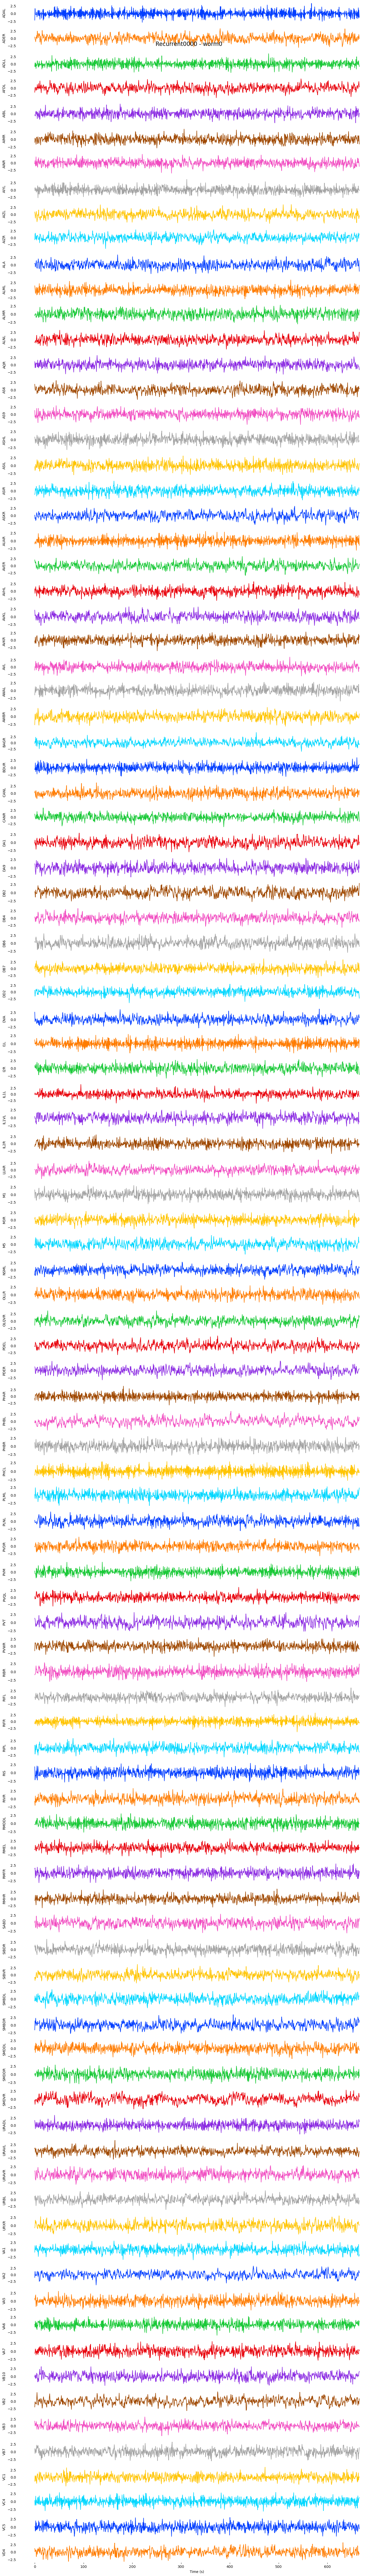

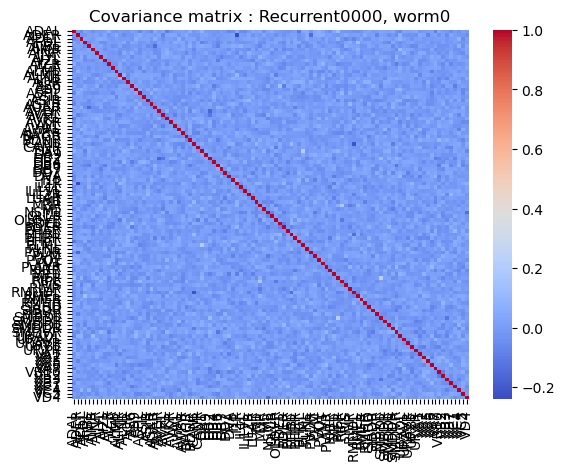

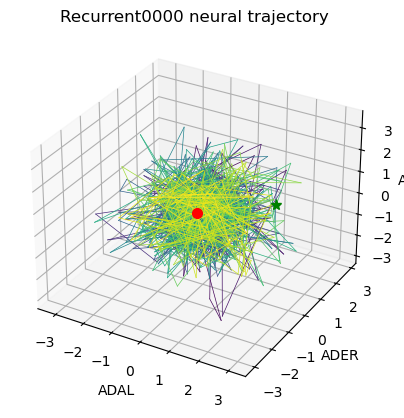

In [110]:
# Selecting a worm and all the neurons to plot
worm_idx = random.choice([f"worm{i}" for i in range(num_worms)])
neuron_idx = [idx for idx in dataset[worm_idx]["slot_to_neuron"].keys()][:num_named_neurons]

# Plotting dataset
plot_neural_signals(
    data=dataset[worm_idx]["calcium_data"],
    time_tensor=dataset[worm_idx]["time_in_seconds"],
    neuron_idx=neuron_idx,
    yax_limit=False,
    suptitle=f"{dataset_name} - {worm_idx}",
)

# Visualize covariance matrix
data = dataset[worm_idx]["calcium_data"]
mask = dataset[worm_idx]["named_neurons_mask"]
neurons = sorted(dataset[worm_idx]["named_neuron_to_slot"])

X = data[:, mask].numpy()
n = X.shape[0]
# centering the data here is redundant if StandardScaler was used when creating the dataset
X_bar = X - np.mean(X, axis=0, keepdims=True)
cov = 1 / (n - 1) * X_bar.T @ X_bar

plt.figure()
ax = sns.heatmap(cov, cmap="coolwarm", xticklabels=neurons, yticklabels=neurons)
ax.set_title(f"Covariance matrix : {dataset_name}, {worm_idx}")
plt.show()

# Plotting 3D trajectory
plot_3d_trajectory(X, axis_labels=tuple(neurons), title=f"{dataset_name} neural trajectory")

##### Analysis of recurrent network system recovery from sparse data

Let us rearrange the discrete-time update equation from earlier:

$$ \mathbf{x}(t + \Delta t) = \left(1 - \alpha\right) \mathbf{x}(t) + \alpha \mathbf{M} f(\mathbf{x}) + \alpha \mathbf{b}(t) $$

in a way that makes the "push-forward" function more obvious and makes the matrix we wish to recover from the data more explicit. 

**N.B.**: What we refer to as the "push-forward" is the function the maps from the current state at time $t$ to the subsequent state at time $t+\Delta t$.

We will make use of the linear approximation $f(x) \approx x$ for small $x$:

$$ \left[ \left(1 - \alpha\right) \mathbf{I}  + \alpha \mathbf{M} \right] \mathbf{x}(t) + \alpha \mathbf{b}(t) = \mathbf{x}(t + \Delta t)$$

Let us define the matrix $\mathbf{B} \triangleq \left[ \left(1 - \alpha\right) \mathbf{I}  + \alpha \mathbf{M} \right]$.

$$\mathbf{B} \mathbf{x}(t) + \alpha \mathbf{b}(t) = \mathbf{x}(t + \Delta t)$$

Multiplying on both sides by $\mathbf{x}(t)^\intercal$ gives:

$$\mathbf{B} \mathbf{x}(t)\mathbf{x}(t)^\intercal + \alpha \mathbf{b}(t)\mathbf{x}(t)^\intercal = \mathbf{x}(t + \Delta t)\mathbf{x}(t)^\intercal$$

Since $\mathbf{x}(t)$ is a vector we know that the matrices $\mathbf{x}(t)\mathbf{x}(t)^\intercal, \mathbf{b}(t)\mathbf{x}(t)^\intercal, \mathbf{x}(t + \Delta t)\mathbf{x}(t)^\intercal$ are all rank-$1$ and thus not invertible. But since we have multiple samples (a.k.a observations or measurements) of the state $\mathbf{x}(t), t \in \{0,1,2, ...,T\}$ the corresponding sample covariance matrices:

$$
\begin{aligned}
\hat{\mathbf{\Sigma}}_x &= \frac{1}{T} \sum_{t=0}^{T}\mathbf{x}(t)\mathbf{x}(t)^\intercal \\
\hat{\mathbf{\Sigma}}_{bx} &= \frac{1}{T} \sum_{t=0}^{T} {\mathbf{b}(t)\mathbf{x}(t)^\intercal} \\
\hat{\mathbf{\Sigma}}_{{\Delta t}x} &= \frac{1}{T} \sum_{t=0}^{T}\mathbf{x}(t + \Delta t)\mathbf{x}(t)^\intercal
\end{aligned}
$$

will be full rank, and thus invertible, if a minimal set $\geq \operatorname{dim}(\mathbf{x})$ of linearly independent states are sampled. If suffficiently rich dynamics are present then the probability of this being true $\to 1$ as $T \to \infty$.

$$
\begin{aligned}
\hat{\mathbf{B}}\hat{\mathbf{\Sigma}}_x + \alpha \hat{\mathbf{\Sigma}}_{bx} &= \hat{\mathbf{\Sigma}}_{{\Delta t}x} \\
\rightarrow \hat{\mathbf{B}} &= \left( \hat{\mathbf{\Sigma}}_{{\Delta t}x} - \alpha \hat{\mathbf{\Sigma}}_{bx} \right) \left( \hat{\mathbf{\Sigma}}_x \right)^{-1}
\end{aligned}
$$

We can think of the external input $\mathbf{b}$ as the environment, which is impossible to measure perfectly and often not measured at all. However, we can simplify the problem of recovering the matrix $\mathbf{B}$ by assuming either: 
 1. no external input $\mathbf{b}(t) = \mathbf{0}$, or
 2. the input and state are uncorrelated $\hat{\mathbf{\Sigma}}_{bx} = \mathbf{0}$.

**N.B.** Neither of these assumptions are fully valid in the real world but the second one is a slightly more reasonable. The second assumption essentially says that the environment is independent of the network state.

With the above assumptions, the equation for recovering the matrix $\mathbf{B}$ from observations/measurement data simplifies to:
$$
\hat{\mathbf{B}} = \hat{\mathbf{\Sigma}}_{{\Delta t} x} \left( \hat{\mathbf{\Sigma}}_x \right)^{-1}
$$


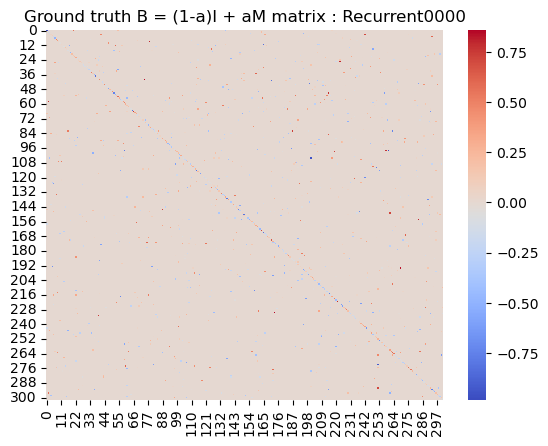

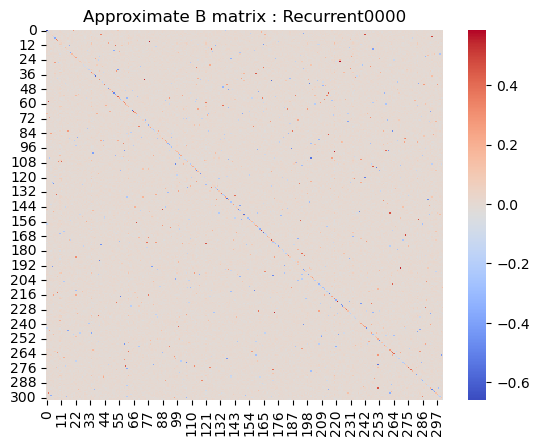

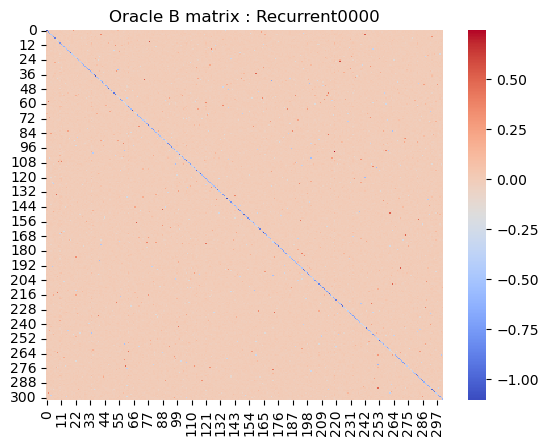

Oracle B diagonal (min, max): (-1.103112626056761, 0.0978341383162876)

Oracle B eigenvalues (min, max): (-1.0556312121246956, 0.27685798157181385)


estimate oracle distance (B - oracle_B): 10.57643572499523

total_mask: [[73. 31. 25. ... 21. 22. 22.]
 [31. 75. 26. ... 21. 20. 25.]
 [25. 26. 75. ... 22. 24. 27.]
 ...
 [21. 21. 22. ... 59. 20. 18.]
 [22. 20. 24. ... 20. 66. 18.]
 [22. 25. 27. ... 18. 18. 61.]]

num_worms: 200

number of neurons never observed: 0

cov_x symmetric: True
cov_x rank: 302
cov_x determinant 3.741159991663249e-08
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
cov_dtx symmetric: False
cov_dtx rank: 302
cov_dtx determinant 4.967315648292037e-187

True B diagonal (min, max): (-0.983239188089386, 0.7932949434362998)
Approximate B diagonal (min, max): (-0.6585511124855618, 0.5560903949912122)

True B eigenvalues (min, max): (-1.0000000000000009, 0.7776015676792237)
Approximate B eigenvalues (min, max): (-0.6695972545441715, 0.9524923423623162)


estimate full 

In [113]:
cov_x = np.zeros((num_signals, num_signals))
cov_dtx = np.zeros((num_signals, num_signals))
cov_bx = np.zeros((num_signals, num_signals))  # oracle knowledge
total_mask = np.zeros((num_signals, num_signals))
M = None
cap = 200  # < num_worms
for idx in range(min(cap, num_worms)):
    # Get current worm ID
    worm_idx = f"worm{idx}"
    # Check that "connectome" is the same for all worms
    if M is None:
        M = dataset[worm_idx]["extra_info"]["connection_weights"]
        A = dataset[worm_idx]["extra_info"]["adjacency_matrix"]
        a = dataset[worm_idx]["extra_info"]["alpha"]  # oracle
    else:
        M_ = dataset[worm_idx]["extra_info"]["connection_weights"]
        assert np.allclose(M, M_), "Inconsisent connection weights!"
        M = M_
        A_ = dataset[worm_idx]["extra_info"]["adjacency_matrix"]
        assert np.allclose(A, A_), "Inconsistent adjacency matrix!"
        A = A_
        a_ = dataset[worm_idx]["extra_info"]["alpha"]
        assert np.allclose(a, a_), "Inconsistent alpha!"
        a = a_
    # Compute matrices needed to estimate the connectivity matrix
    mask = dataset[worm_idx]["named_neurons_mask"].numpy().reshape(1, -1)
    data = dataset[worm_idx]["calcium_data"].numpy()
    # Having the inputs requires an oracle or perfect meaasurement of the environment
    inputs = dataset[worm_idx]["extra_info"]["input_matrix"]  # (T, num_signals)
    b = inputs
    X = data
    T = data.shape[0]
    S = mask.T @ mask
    total_mask += S
    # # (num_signals, T) x (T, num_signals) -> (num_signals, num_signals)
    # cov_x += ( (X[:-1].T @ X[:-1]) / T ) * S
    # cov_dtx += ( (X[1:].T @ X[:-1]) / T ) * S
    # cov_bx += ( (b[:-1].T @ X[:-1] ) / T ) * S
    ### DEBUG ###
    # Idea: Reduced dependence between far apart state samples
    inds = np.unique(np.linspace(1, T - 1, 2 * num_signals, dtype=int))
    cov_x += ((X[inds - 1].T @ X[inds - 1]) / len(inds)) * S
    cov_dtx += ((X[inds].T @ X[inds - 1]) / len(inds)) * S
    cov_bx += ((b[inds - 1].T @ X[inds - 1]) / len(inds)) * S
    ### DEBUG ###
total_mask = np.clip(total_mask, a_min=1, a_max=None)

# True B = (1-a)I + aM matrix
I = np.eye(num_signals)
B = (1 - a) * I + a * I @ M

# Average covariance matrices over repetitions of the same neuron across all worms
cov_x = np.divide(cov_x, total_mask)
cov_dtx = np.divide(cov_dtx, total_mask)
cov_bx = np.divide(cov_bx, total_mask)

# Estimator of B matrix
approx_B = cov_dtx @ np.linalg.pinv(cov_x)

# Plot figures
plt.figure()
ax = sns.heatmap(B, cmap="coolwarm")
ax.set_title(f"Ground truth B = (1-a)I + aM matrix : {dataset_name}")
plt.show()

plt.figure()
ax = sns.heatmap(approx_B, cmap="coolwarm")
ax.set_title(f"Approximate B matrix : {dataset_name}")
plt.show()

### DEBUG ###
# Estimate of B matrix given oracle knowledge of alpha (a) and input (b)
# TODO: WHY IS THIS WORSE THAN THE APPROXIMATION?!
oracle_B = (cov_dtx - a * I @ cov_bx) @ np.linalg.pinv(cov_x)
plt.figure()
ax = sns.heatmap(oracle_B, cmap="coolwarm")
ax.set_title(f"Oracle B matrix : {dataset_name}")
plt.show()
print(f"Oracle B diagonal (min, max): {np.diag(oracle_B).min(), np.diag(oracle_B).max()}\n")
print(
    f"Oracle B eigenvalues (min, max): {np.linalg.eigvals(oracle_B).real.min(), np.linalg.eigvals(oracle_B).real.max()}\n",
    end="\n\n",
)
print(
    "estimate oracle distance (B - oracle_B):", np.linalg.norm(B - oracle_B, ord="fro"), end="\n\n"
)
### DEBUG ###

print(f"total_mask: {total_mask}\n")
print(f"num_worms: {num_worms}\n")
print("number of neurons never observed:", (np.diag(total_mask) <= 1).sum(), end="\n\n")

print("cov_x symmetric:", scp.linalg.issymmetric(cov_x))
print("cov_x rank:", np.linalg.matrix_rank(cov_x))
print("cov_x determinant", np.linalg.det(cov_x))
print("~" * 50)
print("cov_dtx symmetric:", scp.linalg.issymmetric(cov_dtx))
print("cov_dtx rank:", np.linalg.matrix_rank(cov_dtx))
print("cov_dtx determinant", np.linalg.det(cov_dtx), end="\n\n")

print(
    f"True B diagonal (min, max): {np.diag(B).min(), np.diag(B).max()}\n"
    f"Approximate B diagonal (min, max): {np.diag(approx_B).min(), np.diag(approx_B).max()}\n"
)
print(
    f"True B eigenvalues (min, max): {np.linalg.eigvals(B).real.min(), np.linalg.eigvals(B).real.max()}\n"
    f"Approximate B eigenvalues (min, max): {np.linalg.eigvals(approx_B).real.min(), np.linalg.eigvals(approx_B).real.max()}\n",
    end="\n\n",
)

print("estimate full distance (B - approx_B):", np.linalg.norm(B - approx_B, ord="fro"))

print(
    "(distribution) chance distance:", np.linalg.norm(B - np.random.randn(*B.shape), ord="fro")
)  # if all you knew was that the weights were ~N(0,1)
print(
    "(adjacency + distribution) chance distance:",
    np.linalg.norm(B - A * np.random.randn(*B.shape), ord="fro"),
)  # if you additionally knew the adjacency matrix
print(
    "(sign + adjacency + distribution) chance distance:",
    np.linalg.norm(B - A * np.sign(B) * np.abs(np.random.randn(*B.shape)), ord="fro"),
    end="\n\n",
)  # if you additionally knew the signs of the weights

sensorium: [10, 11, 34, 62, 106, 121, 198, 219, 233, 282]
sensory neurons: ['AIAL' 'AIAR' 'AS5' 'AVFR' 'DD3' 'I3' 'RIH' 'RMGL' 'SIADR' 'VB9']


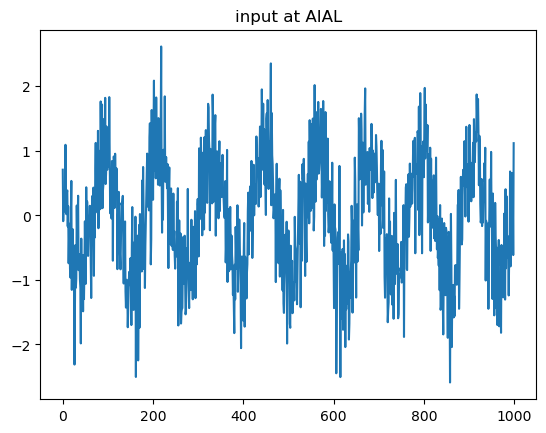

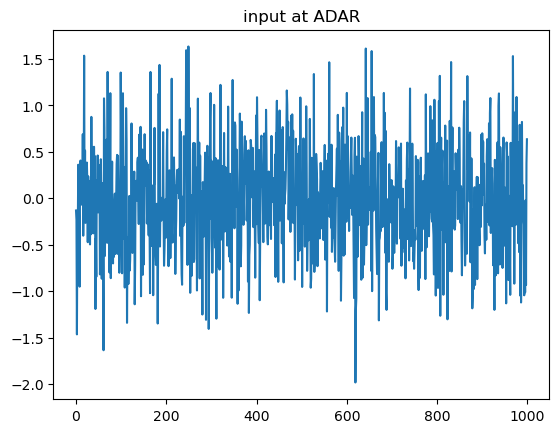

In [114]:
### DEBUG ###
s = dataset[worm_idx]["extra_info"]["sensorium"]
print("sensorium:", s)
print("sensory neurons:", np.array(NEURON_LABELS)[s])

plt.figure()
plt.plot(b[:, s[0]])
plt.title(f"input at {np.array(NEURON_LABELS)[s[0]]}")
plt.show()

plt.figure()
plt.plot(b[:, 1])
plt.title(f"input at {np.array(NEURON_LABELS)[1]}")
plt.show()
### DEBUG ###

##### Learning time constants $\alpha$ and connectivity $M$ given an estimator of $\hat{B}$

The relationship between the correlation coefficient matrix, $R$, and the covariance matrix, $C$, is:

$$R_{ij} = \frac{ C_{ij} } { \sqrt{ C_{ii} C_{jj} } }$$

The values of $R$ are between $-1$ and $1$, inclusive.

We have normalized the trace of each neuron to be zero-mean and unit-variance for our datasets (simulated and real). Therefore, the covariance matrix $C$ is equivalent to the correlation matrix $R$.

---

After estimating $\mathbf{B}$ above, we can use the definition $\mathbf{B} = \left[ \left(1 - \alpha\right) \mathbf{I}  + \alpha \mathbf{M} \right]$ to to solve for $\alpha$ and $\mathbf{M}$ using convex optimization or gradient descent.

---

We can approach this problem using PyTorch to implement a neural network model that learns the parameters $\alpha$ and $\mathbf{M}$ through backpropagation. This approach refelcts a teacher-student setup, where the teacher (the fixed matrix $\mathbf{B}$) generates target outputs $y$ using random inputs $x$, and the student (the neural network) tries to learn to replicate this mapping.

**Set-up**

1. **Generate Data**: Create pairs of inputs $x$ and targets $y$ using $\mathbf{B}$.
2. **Define the Model**: The model will represent $(1-\alpha) \mathbf{I} + \alpha \mathbf{M}$, where $\alpha$ and $\mathbf{M}$ are trainable parameters.
3. **Training**: Use a loss function (like mean squared error) to measure the difference between the network output and the target $y$, and use an optimizer to update $\alpha$ and $\mathbf{M}$.

**Explanation**

- **Model Setup**: The model consists of parameters $\alpha$ and $\mathbf{M}$. 
- **Data Generation**: Data pairs $(x, y)$ are generated using $\mathbf{B}$, where $x$ is drawn from a standard normal distribution and $y$ is computed as $\mathbf{B}x$.
- **Training**: We use a simple training loop with an Adam optimizer. Mean squared error (MSE) measures how well the model's outputs match the targets generated using $\mathbf{B}$.


In [103]:
class LinearModel(torch.nn.Module):
    def __init__(self, N=approx_B.shape[0], learn_alpha=False):
        super(LinearModel, self).__init__()
        if learn_alpha:
            self.alpha = torch.nn.Parameter(torch.full((N,), 0.5))  # Vector alpha (learnable)
        else:
            alpha = torch.ones(N)  # Vector alpha (fixed at 1)
            self.register_buffer("alpha", alpha)
        M = torch.eye(N)  # Initialize M to the identity matrix
        self.M = torch.nn.Parameter(M)  # Matrix M
        self.N = N

    def forward(self, x):
        """
        x should have shape (N, num_samples).
        """
        I = torch.eye(self.N, device=x.device)
        B_model = torch.mul(1 - self.alpha.unsqueeze(1), I) + torch.mul(
            self.alpha.unsqueeze(1), self.M
        )
        return B_model @ x  # (N, N) @ (N, num_samples) -> (N, num_samples)


def generate_data(B=approx_B, num_samples=1000):
    N = B.shape[0]
    B_tensor = torch.tensor(B, dtype=torch.float32)  # Convert B to a PyTorch tensor
    x = torch.randn(num_samples, N)
    y = (B_tensor @ x.T).T  # Corrected matrix multiplication
    return x, y  # (num_samples, N), (num_samples, N)


def train_model(model, batch_size=1000, epochs=100, lr=0.01, lambda_l1=0.01):
    """
    Method 1: Projection
    This method involves directly clipping the alpha values after each gradient step within the training loop.
    """
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        x, y = generate_data(B=approx_B, num_samples=batch_size)
        outputs = model(x.T)  # Transpose x here
        loss = criterion(outputs.T, y)  # Transpose outputs back to match y
        diagonal = torch.diag(model.M)
        # Impose L1 penalty only on the off-diagonal elements
        l1_penalty = lambda_l1 * torch.sum(torch.abs(model.M - torch.diagflat(diagonal)))
        total_loss = loss + l1_penalty
        total_loss.backward()
        optimizer.step()
        if epoch % int(epochs**0.333) == 0:
            print(
                f"Epoch {epoch+1}, Loss: {total_loss.item()}, \n\tBase Loss: {loss.item()}, \n\tL1 Penalty: {l1_penalty.item()}\n"
            )


# Example usage
model = LinearModel(N=approx_B.shape[0])
train_model(model, batch_size=1000, epochs=1000, lr=0.01, lambda_l1=1e-6)

Epoch 1, Loss: 1.2823408842086792, 
	Base Loss: 1.2823408842086792, 
	L1 Penalty: 0.0

Epoch 10, Loss: 1.0733336210250854, 
	Base Loss: 1.0718269348144531, 
	L1 Penalty: 0.001506744883954525

Epoch 19, Loss: 0.851233959197998, 
	Base Loss: 0.8498807549476624, 
	L1 Penalty: 0.001353215309791267

Epoch 28, Loss: 0.6883601546287537, 
	Base Loss: 0.6871472597122192, 
	L1 Penalty: 0.0012128847884014249

Epoch 37, Loss: 0.5509742498397827, 
	Base Loss: 0.5498035550117493, 
	L1 Penalty: 0.00117070646956563

Epoch 46, Loss: 0.4431372880935669, 
	Base Loss: 0.44198518991470337, 
	L1 Penalty: 0.00115210039075464

Epoch 55, Loss: 0.3516213595867157, 
	Base Loss: 0.35052490234375, 
	L1 Penalty: 0.0010964585235342383

Epoch 64, Loss: 0.27867183089256287, 
	Base Loss: 0.2776182293891907, 
	L1 Penalty: 0.001053612562827766

Epoch 73, Loss: 0.219171941280365, 
	Base Loss: 0.2181500345468521, 
	L1 Penalty: 0.0010219099931418896

Epoch 82, Loss: 0.1724555790424347, 
	Base Loss: 0.17145821452140808, 
	L1

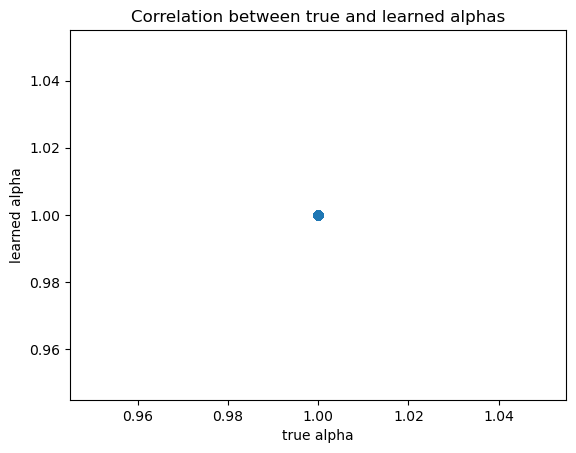

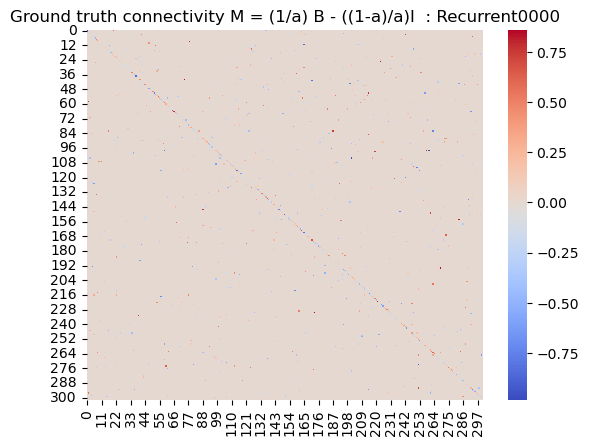

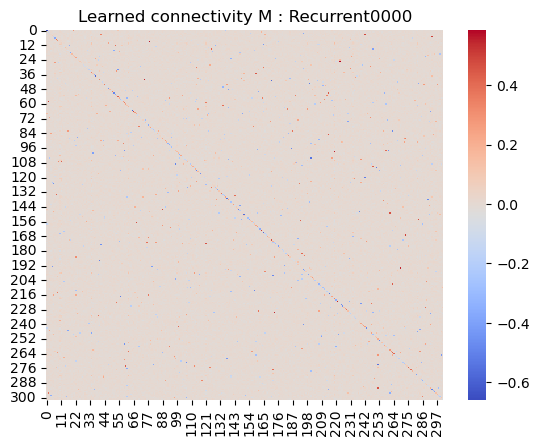

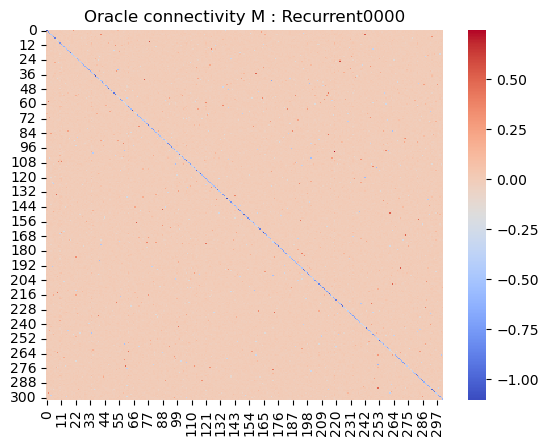

Oracle connectivity diagonal (min, max): (-1.103112626056761, 0.0978341383162876)

Learned connectivity eigenvalues (min, max): (-1.0556312121246956, 0.27685798157181385)


estimate oracle distance (M - oracle_M): 10.57643572499523

True connectivity diagonal (min, max): (-0.983239188089386, 0.7932949434362998)
Learned connectivity diagonal (min, max): (-0.65854317, 0.55613834)

True connectivity eigenvalues (min, max): (-1.0000000000000009, 0.7776015676792237)
Learned connectivity eigenvalues (min, max): (-0.6696053, 0.95048547)


estimate full distance (M - learned_M): 4.53378419266158

(distribution) chance distance: 301.7258901411673
(adjacency + distribution) chance distance: 38.34016796662395
(sign + adjacency + distribution) chance distance: 30.961157798380228



In [104]:
learned_a = model.alpha.detach().numpy()
learned_M = model.M.detach().numpy()

plt.figure()
plt.scatter(a, learned_a)
plt.xlabel("true alpha")
plt.ylabel("learned alpha")
plt.title("Correlation between true and learned alphas")
plt.show()

plt.figure()
ax = sns.heatmap(M, cmap="coolwarm")  # , xticklabels=NEURON_LABELS, yticklabels=NEURON_LABELS)
ax.set_title(f"Ground truth connectivity M = (1/a) B - ((1-a)/a)I  : {dataset_name}")
plt.show()

plt.figure()
ax = sns.heatmap(learned_M, cmap="coolwarm")  # , xticklabels=NEURON_LABELS, yticklabels=NEURON_LABELS)
ax.set_title(f"Learned connectivity M : {dataset_name}")
plt.show()

### DEBUG ###
oracle_M = 1 / a * I @ oracle_B - (1 - a) / a * I
plt.figure()
ax = sns.heatmap(oracle_M, cmap="coolwarm")  # , xticklabels=NEURON_LABELS, yticklabels=NEURON_LABELS)
ax.set_title(f"Oracle connectivity M : {dataset_name}")
plt.show()
print(
    f"Oracle connectivity diagonal (min, max): {np.diag(oracle_M).min(), np.diag(oracle_M).max()}\n"
)
print(
    f"Learned connectivity eigenvalues (min, max): {np.linalg.eigvals(oracle_M).real.min(), np.linalg.eigvals(oracle_M).real.max()}\n",
    end="\n\n",
)
print(
    "estimate oracle distance (M - oracle_M):", np.linalg.norm(M - oracle_M, ord="fro"), end="\n\n"
)
### DEBUG ###

print(
    f"True connectivity diagonal (min, max): {np.diag(M).min(), np.diag(M).max()}\n"
    f"Learned connectivity diagonal (min, max): {np.diag(learned_M).min(), np.diag(learned_M).max()}\n"
)
print(
    f"True connectivity eigenvalues (min, max): {np.linalg.eigvals(M).real.min(), np.linalg.eigvals(M).real.max()}\n"
    f"Learned connectivity eigenvalues (min, max): {np.linalg.eigvals(learned_M).real.min(), np.linalg.eigvals(learned_M).real.max()}\n",
    end="\n\n",
)

print(
    "estimate full distance (M - learned_M):", np.linalg.norm(M - learned_M, ord="fro"), end="\n\n"
)

print(
    "(distribution) chance distance:", np.linalg.norm(M - np.random.randn(*M.shape), ord="fro")
)  # if all you knew was that the weights were ~N(0,1)
print(
    "(adjacency + distribution) chance distance:",
    np.linalg.norm(M - A * np.random.randn(*M.shape), ord="fro"),
)  # if you additionally knew the adjacency matrix
print(
    "(sign + adjacency + distribution) chance distance:",
    np.linalg.norm(M - A * np.sign(M) * np.abs(np.random.randn(*M.shape)), ord="fro"),
    end="\n\n",
)  # if you additionally knew the signs of the weights

**Key takeaways:**

* Solving for the connectivity matrix is impossible without input noise, even though when we wrote the equation we ignore the noise because we don't know it!

* Solving for the connectivity was near impossible with $\alpha \neq 1$. Going forward we will only make simulations with $\alpha=1$, in which case the matrix $B$ is equal to the connectivity matrix $M$ (i.e. $B \equiv M$).

* Also, we don't know the time constants but that ends up not making a huge difference to our empirical results!

* Minimally connectedness seems to be extremely necessary to be able to estimate the connectivity matrix. Densely connected networks are near impossible to estimate. Although we don't understand mathematically why, it is likely because of the multiple pathways that influence a node's activity. 

* It seems more important to have more recorded neurons per worm and have fewer worms than to have have many worms with only a few recorded neurons. So the optimizing the number of neurons recorded per animal is more important than improving the throughput of animals.
    * Update: It is still possible to estimate densely connected networks but there now needs to be noise injected at almost every node independently.
    * So it seems that the less sparse/more dense/more connected the network is, the larger the percentage of the network that is the sensorium needs to be so that noise can get injected there.

* Initialization of the $M$ matrix as a parameter is very important. The closer we can initialize it to the true connectivity, the better our learned approximation is to the truth. But obviously in the real world we don't have any hints about the initialization. Empirically we find initializing to the identity matrix works fairly well. 

* A critical threshold of sensory neurons (i.e. nodes alowed to receive external inputs) needs to be passed ($\approx 200$ out of the $302$ at maximum sparsity for connectedness) for the connections weights to be recoverable. It remains to be seen whether the external inputs $b$ must be Gaussian white nose or whether they can be a time-varying smooth signal.
    * System recovery works optimially for time-independent Gaussian noise input signal.
    * System recovery fails for high-frequency time-varying input signal, even when frequency is on the order of the number of measurement timesteps.
    * Adding noise to a high-frequency time-varying input signal make improves system recovery.
    * System recovery fails for a low-frequency time-varying input signal.
    * Adding noise to a low-frequency time-varying input signal allows some system recovery.

* So really all you need is away to inject a significant amount of noise into your system and you can recover the weights. The signal to-noise ratio foe the external input needs to be quit for us to be able to estimate the connectivity weights.
    
    

#### Sines dataset
---

In [ ]:
def create_synthetic_dataset_sines(
    max_timesteps: int = 1000,
    num_worms: int = 1,
    num_signals: int = 302,
    num_named_neurons: Union[None, int] = None,
    add_noise: bool = False,
    noise_std: float = 0.01,
    random_walk: bool = False,
    sum_frequencies: int = 1,
    random_freqs: bool = False,
    delta_seconds: float = 0.5,
    smooth_method: Union[None, str] = "ES",
    transform: Union[
        None, callable
    ] = StandardScaler(),  # StandardScaler(), #CausalNormalizer() #None
    dataset_name: str = "Sines0000",
):
    """
    Create a synthetic worm datasets using a sum of sinusoidal functions.
    Out of the `num_signals` neurons, `num_named_neurons` neurons are chosen randomly
    to have non-zero (i.e. "measured") signals. Each neuron's calcium signal is a sinusoid
    with `sum_frequencies` frequencies added together and a random phase. Each neuron class
    has a distinct frequency fingerprint (i.e. the particular frequencies summed together).

    :param max_timesteps: The number of timepoints of synthetic data to generate.
    :param num_worms: The number of synthetic worms to create datasets for.
    :param num_signals: The number of signals corresponding to number of neurons.
    :param num_named_neurons: The number of measured neurons to create non-zero signals for.
    :param add_noise: Whether to simulate observation noise by adding Gaussian noise to the synthetic data.
    :param noise_std: The standard deviation of the noise.
    :param random_walk: If True, use a random walk to generate the noise. Otherwise, use iid noise.
    :param sum_frequencies: The number of sine functions to add together to create a signal.
    :param random_freqs: If True, use random frequencies for each neuron. Otherwise, use the same frequencies for all neurons.
    :param delta_seconds: The constant time difference (in seconds) between each timepoint.
    :param smooth_method: The method to use for smoothing the data.
    :param transform: The sklearn method to scale or transform the data before use.
    :param dataset_name: The name to give the synthetic dataset.
    :return: A dictionary containing the synthetic worm datasets.
    """
    eps = np.finfo(float).eps
    dataset = {}
    # Determine the timepoints for sampling the data (i.e. "measurement" times)
    time_in_seconds = delta_seconds * np.arange(max_timesteps).reshape(-1, 1)  # column vector
    # Create a memo of neurons to frequencies so that distinct neurons have distinct frequency signatures
    neuron_to_frequencies = dict()  # this will be consistent across worms
    # Calculate number of named and unknown neurons
    if num_named_neurons is None or num_named_neurons > num_signals:  # default to all neurons
        num_named_neurons = num_signals
    elif num_named_neurons < 0:  # default to no neurons
        num_named_neurons = 0
    num_unknown_neurons = num_signals - num_named_neurons
    # Create data for each worm
    for worm_idx in range(num_worms):
        # Create a memo of neurons to phases so that distinct neurons have distinct phase signatures
        neuron_to_phases = dict()  # this will vary across worms
        # Initialize worm data
        worm = f"worm{worm_idx}"
        worm_data = {}
        calcium_data = np.zeros((max_timesteps, num_signals))
        # Choose a random subset of neurons to record / observe / measure
        named_neuron_indices = random.sample(
            range(num_signals), num_named_neurons
        )  # without replacement
        named_neurons = set(NEURON_LABELS[i] for i in named_neuron_indices)
        # Create neuron to idx mapping and vice versa
        neuron_to_idx = {
            (neuron) if neuron in named_neurons else str(idx): idx
            for idx, neuron in enumerate(NEURON_LABELS)
        }
        idx_to_neuron = {idx: neuron for neuron, idx in neuron_to_idx.items()}
        # Create calcium data
        for i in named_neuron_indices:
            neuron_index = i
            neuron_name = NEURON_LABELS[neuron_index]
            # Each neuron class has a distinct and deterministic frequency fingerprint
            frequencies = neuron_to_frequencies.setdefault(
                neuron_name,
                (
                    np.round(
                        eps + np.random.random(sum_frequencies) / 10, 4
                    ).tolist()  # random frequencies
                    if random_freqs
                    else np.round(
                        np.arange(1 / (2 * sum_frequencies + eps), sum_frequencies)
                        / (10 * sum_frequencies),
                        4,
                    ).tolist()
                ),  # deterministic frequencies
            )
            # All neuron classes have a distinct but random phase offset
            phases = neuron_to_phases.setdefault(
                neuron_name,
                [np.random.random() * 2 * np.pi for _ in range(sum_frequencies)],  # random phase
            )
            time_points = np.arange(max_timesteps)
            # Add sine functions together to create the simulated calcium signal
            for freq, phase in zip(frequencies, phases):
                calcium_data[:, neuron_index] += np.sin(2 * np.pi * freq * time_points + phase)
            # Add measurement/observation noise
            if add_noise:
                if random_walk:
                    noise_walk = np.cumsum(
                        [0]
                        + np.random.normal(loc=0, scale=noise_std, size=max_timesteps - 1).tolist()
                    )
                    calcium_data[:, neuron_index] += noise_walk
                else:
                    noise_iid = np.random.normal(0, noise_std, max_timesteps)
                    calcium_data[:, neuron_index] += noise_iid
        # Normalize the data
        if transform:
            calcium_data = transform.fit_transform(calcium_data)
        # Calculate residuals
        dt = np.diff(time_in_seconds, axis=0, prepend=0.0)
        resample_dt = np.median(dt[1:]).item()
        residual_calcium = np.gradient(calcium_data, time_in_seconds.squeeze(), axis=0)
        # Smooth the data
        smooth_calcium_data = smooth_data_preprocess(
            calcium_data, time_in_seconds, smooth_method, **dict(alpha=0.5, window_size=15, sigma=5)
        )
        smooth_residual_calcium = smooth_data_preprocess(
            residual_calcium,
            time_in_seconds,
            smooth_method,
            **dict(alpha=0.5, window_size=15, sigma=5),
        )
        # Build the dataset
        worm_data["worm"] = worm
        worm_data["source_dataset"] = dataset_name
        worm_data["smooth_method"] = smooth_method
        worm_data["num_neurons"] = num_signals
        worm_data["num_named_neurons"] = num_named_neurons
        worm_data["num_unknown_neurons"] = num_unknown_neurons
        worm_data["time_in_seconds"] = time_in_seconds
        worm_data["dt"] = dt
        worm_data["max_timesteps"] = max_timesteps
        worm_data["median_dt"] = resample_dt
        worm_data["calcium_data"] = calcium_data
        worm_data["smooth_calcium_data"] = smooth_calcium_data
        worm_data["residual_calcium"] = residual_calcium
        worm_data["smooth_residual_calcium"] = smooth_residual_calcium
        worm_data["neuron_to_idx"] = neuron_to_idx
        worm_data["idx_to_neuron"] = idx_to_neuron
        worm_data["extra_info"] = {
            "neuron_to_frequencies": neuron_to_frequencies,
            "neuron_to_phases": neuron_to_phases,
            "meta_text": "This dataset simulates neural activity data as the sum of sinusoidal functions with distinct frequency and phase fingerprints for each neuron class.\n"
            "The 'fingerprint' for each neuron class is the particular set deterministic frequencies that are summed to give that neuron's signal and each neuron class has a distinct but random phase offset.\n",
        }
        # Reshape the data to the standardized format
        worm_data = reshape_calcium_data(worm_data)
        # Save the data
        dataset[worm] = worm_data
    return dataset

In [ ]:
# Initialize parameters
max_timesteps = 1000
num_worms = 200
num_signals = 302
# reflect a cost-benefit tradeoff between throughput and accuracy
num_named_neurons = num_signals - num_worms
add_noise = False
noise_std = 0.1
random_walk = False
# a single frequency per fingerprint
sum_frequencies = 1
random_freqs = True
delta_seconds = 1.0
smooth_method = None
transform = StandardScaler()
dataset_name = "Sines0000"

# Creating and saving datasets
dataset = create_synthetic_dataset_sines(
    max_timesteps=max_timesteps,
    num_worms=num_worms,
    num_signals=num_signals,
    num_named_neurons=num_named_neurons,
    add_noise=add_noise,
    noise_std=noise_std,
    random_walk=random_walk,
    sum_frequencies=sum_frequencies,
    random_freqs=random_freqs,
    delta_seconds=delta_seconds,
    smooth_method=smooth_method,
    transform=transform,
    dataset_name=dataset_name,
)

# Save the dataset
save_synthetic_dataset(f"processed/neural/{dataset_name}.pickle", dataset)

In [ ]:
# Selecting a worm and all the neurons to plot
worm_idx = random.choice([f"worm{i}" for i in range(num_worms)])
neuron_idx = [idx for idx in dataset[worm_idx]["slot_to_neuron"].keys()][:num_named_neurons]

# Plotting dataset
plot_neural_signals(
    data=dataset[worm_idx]["calcium_data"],
    time_tensor=dataset[worm_idx]["time_in_seconds"],
    neuron_idx=neuron_idx,
    yax_limit=False,
    suptitle=f"{dataset_name} - {worm_idx}",
)

# Visualize covariance matrix
data = dataset[worm_idx]["calcium_data"]
mask = dataset[worm_idx]["named_neurons_mask"]
neurons = sorted(dataset[worm_idx]["named_neuron_to_slot"])

X = data[:, mask].numpy()
n = X.shape[0]
X_bar = X - np.mean(X, axis=0, keepdims=True)
cov = 1 / (n - 1) * X_bar.T @ X_bar

plt.figure()
ax = sns.heatmap(cov, cmap="coolwarm", xticklabels=neurons, yticklabels=neurons)
ax.set_title(f"Covariance matrix : {dataset_name}, {worm_idx}")
plt.show()

# Plotting 3D trajectory
plot_3d_trajectory(X, axis_labels=tuple(neurons), title=f"{dataset_name} neural trajectory")

#### Lorenz dataset
---

In [ ]:
def create_synthetic_dataset_lorenz(
    max_timesteps: int = 1000,
    num_worms: int = 1,
    num_signals: int = 302,
    num_lorenz_systems: int = 1,
    add_noise: bool = False,
    noise_std: float = 0.01,
    random_walk: bool = False,
    fine_integration_step: float = 0.1,
    delta_seconds: float = 0.5,
    smooth_method: Union[None, str] = "ES",
    transform: Union[
        None, callable
    ] = StandardScaler(),  # StandardScaler() #CausalNormalizer() #None
    dataset_name: str = "Lorenz0000",
):
    """
    Create a synthetic worm datasets using the Lorenz attractor.
    Three neurons are chosen randomly to represent x, y, z trajectories from the Lorenz system.

    :param max_timesteps: The number of timepoints of synthetic data to generate.
    :param num_worms: The number of synthetic worms to create datasets for.
    :param num_signals: The number of signals corresponding to number of neurons.
    # :param num_lorenz_systems: The number of Lorenz systems to use for creating the synthetic data.
    :param num_named_neurons: The number of measured neurons to create non-zero signals for.
    :param add_noise: Whether to simulate observation noise by adding Gaussian noise to the synthetic data.
    :param noise_std: The standard deviation of the noise.
    :param random_walk: If True, use a random walk to generate the noise. Otherwise, use iid noise.
    :param fine_integration_step: The integration step size for the Lorenz system.
    :param delta_seconds: The constant time difference (in seconds) between each measurement of the system.
    :param smooth_method: The method to use for smoothing the data.
    :param transform: The sklearn method to scale or transform the data before use.
    :param dataset_name: The name to give the synthetic dataset.
    :return: A dictionary containing the synthetic worm datasets.
    """
    eps = np.finfo(float).eps
    dataset = {}

    # Determine the timepoints for sampling the data (i.e. "measurement" times)
    time_in_seconds = delta_seconds * np.arange(max_timesteps).reshape(-1, 1)  # Column vector

    # Create a memo of neurons to state variable so that distinct neurons represent a distinct variable
    neuron_to_state_var = dict()  # this will be consistent across worms

    # Calculate number of named and unknown neurons
    num_named_neurons = num_lorenz_systems * 3
    num_unknown_neurons = num_signals - num_named_neurons

    # Fine integration time points for the true underlying dynamics
    fine_time_points = np.arange(0, max_timesteps * delta_seconds, fine_integration_step)

    # Create data for each worm
    for worm_idx in range(num_worms):
        # Initialize worm data
        worm = f"worm{worm_idx}"
        worm_data = {}
        calcium_data = np.zeros((max_timesteps, num_signals))

        # Choose a random subset of neurons to record / observe / measure
        named_neuron_indices = random.sample(
            range(num_signals), num_named_neurons
        )  # without replacement
        named_neurons = set(NEURON_LABELS[i] for i in named_neuron_indices)

        # Create neuron to idx mapping and vice versa
        neuron_to_idx = {
            (neuron) if neuron in named_neurons else str(idx): idx
            for idx, neuron in enumerate(NEURON_LABELS)
        }
        idx_to_neuron = {idx: neuron for neuron, idx in neuron_to_idx.items()}

        # Create calcium data
        calcium_data = np.zeros((max_timesteps, num_signals))

        # Create multiple independent Lorenz systems
        for system_idx in range(num_lorenz_systems):
            # Define a new set of initial conditions for each Lorenz system
            initial_conditions = np.random.uniform(low=-5.0, high=5.0, size=3)
            # np.random.randn(3)  # or other method to generate initial conditions

            # Integrate the Lorenz system with different initial conditions
            fine_trajectories = odeint(lorenz, initial_conditions, fine_time_points)

            # Downsample to get the "measured" data at delta_seconds intervals
            downsample_indices = np.arange(
                0, len(fine_time_points), int(delta_seconds / fine_integration_step)
            )
            sampled_trajectories = fine_trajectories[downsample_indices]

            # Assign to the correct set of neurons for this Lorenz system
            for i in range(3):
                neuron_index = named_neuron_indices[system_idx * 3 + i]
                neuron_name = NEURON_LABELS[neuron_index]

                # Uniquely map each neuron to a committed state variable
                var = neuron_to_state_var.setdefault(neuron_name, i)
                calcium_data[:, neuron_index] = sampled_trajectories[:, var]

                # Add measurement/observation noise
                if add_noise:
                    if random_walk:
                        noise_walk = np.cumsum(
                            [0]
                            + np.random.normal(
                                loc=0, scale=noise_std, size=max_timesteps - 1
                            ).tolist()
                        )
                        calcium_data[:, neuron_index] += noise_walk
                    else:
                        noise_iid = np.random.normal(0, noise_std, max_timesteps)
                        calcium_data[:, neuron_index] += noise_iid

        # Normalize data
        if transform:
            calcium_data = transform.fit_transform(calcium_data)

        # Calculate residuals
        dt = np.diff(time_in_seconds, axis=0, prepend=0.0)
        resample_dt = np.median(dt[1:]).item()
        residual_calcium = np.gradient(calcium_data, time_in_seconds.squeeze(), axis=0)

        # Smooth the data
        smooth_calcium_data = smooth_data_preprocess(
            calcium_data, time_in_seconds, smooth_method, **dict(alpha=0.5, window_size=15, sigma=5)
        )
        smooth_residual_calcium = smooth_data_preprocess(
            residual_calcium,
            time_in_seconds,
            smooth_method,
            **dict(alpha=0.5, window_size=15, sigma=5),
        )

        # Build the dataset
        worm_data["worm"] = worm
        worm_data["source_dataset"] = dataset_name
        worm_data["smooth_method"] = smooth_method
        worm_data["num_neurons"] = num_signals
        worm_data["num_named_neurons"] = num_named_neurons
        worm_data["num_unknown_neurons"] = num_unknown_neurons
        worm_data["time_in_seconds"] = time_in_seconds
        worm_data["dt"] = dt
        worm_data["max_timesteps"] = max_timesteps
        worm_data["median_dt"] = resample_dt
        worm_data["calcium_data"] = calcium_data
        worm_data["smooth_calcium_data"] = smooth_calcium_data
        worm_data["residual_calcium"] = residual_calcium
        worm_data["smooth_residual_calcium"] = smooth_residual_calcium
        worm_data["neuron_to_idx"] = neuron_to_idx
        worm_data["idx_to_neuron"] = idx_to_neuron
        worm_data["extra_info"] = dict()

        # Reshape the data to the standardized format
        worm_data = reshape_calcium_data(worm_data)

        # Save the data
        dataset[worm] = worm_data

    return dataset

In [ ]:
# Initialize parameters
max_timesteps = 1500
num_worms = 200
num_signals = 302
# reflect a cost-benefit tradeoff between throughput and accuracy
num_named_neurons = num_signals - num_worms
num_lorenz_systems = 17
add_noise = False
noise_std = 0.1
random_walk = False
fine_integration_step = 0.04
delta_seconds = 0.04
smooth_method = None
transform = StandardScaler()
dataset_name = "Lorenz0000"

# Creating and saving datasets
dataset = create_synthetic_dataset_lorenz(
    max_timesteps=max_timesteps,
    num_worms=num_worms,
    num_signals=num_signals,
    num_lorenz_systems=num_lorenz_systems,
    add_noise=add_noise,
    noise_std=noise_std,
    random_walk=random_walk,
    fine_integration_step=fine_integration_step,
    delta_seconds=delta_seconds,
    smooth_method=smooth_method,
    transform=transform,
    dataset_name=dataset_name,
)

# Save the dataset
save_synthetic_dataset(f"processed/neural/{dataset_name}.pickle", dataset)

In [ ]:
# Selecting a worm and all the neurons to plot
worm_idx = random.choice([f"worm{i}" for i in range(num_worms)])
neuron_idx = [idx for idx in dataset[worm_idx]["slot_to_neuron"].keys()][: num_lorenz_systems * 3]

# Plotting dataset
plot_neural_signals(
    data=dataset[worm_idx]["calcium_data"],
    time_tensor=dataset[worm_idx]["time_in_seconds"],
    neuron_idx=neuron_idx,
    yax_limit=False,
    suptitle=f"{dataset_name} dataset - {worm_idx}",
)

# Visualize covariance matrix
data = dataset[worm_idx]["calcium_data"]
mask = dataset[worm_idx]["named_neurons_mask"]
neurons = sorted(dataset[worm_idx]["named_neuron_to_slot"])

X = data[:, mask].numpy()
n = X.shape[0]
X_bar = X - np.mean(X, axis=0, keepdims=True)
cov = 1 / (n - 1) * X_bar.T @ X_bar

plt.figure()
ax = sns.heatmap(cov, cmap="coolwarm", xticklabels=neurons, yticklabels=neurons)
ax.set_title(f"Covariance matrix : {dataset_name}, {worm_idx}")
plt.show()

# Plotting 3D trajectory
plot_3d_trajectory(X, axis_labels=tuple(neurons), title=f"{dataset_name} neural trajectory")

### Dynamics datasets
___

We attempt to generalize the previous approaches to generating synthetic data from arbitrary dynamical systems.

In [ ]:
def create_synthetic_dataset_dynamics(
    dynamics_func: callable,
    state_dim: int,
    func_args: tuple = (),
    max_timesteps: int = 1000,
    num_worms: int = 1,
    num_signals: int = 302,
    num_dynamic_systems: int = 1,
    add_noise: bool = False,
    random_walk: bool = False,
    noise_std: float = 0.01,
    fine_integration_step: float = 0.1,
    delta_seconds: float = 0.5,
    smooth_method: Union[None, str] = "ES",
    transform: Union[
        None, callable
    ] = StandardScaler(),  # StandardScaler(), #CausalNormalizer() #None
    dataset_name: str = "Dynamics0000",
):
    """
    Create a synthetic worm dataset using a user-defined dynamical system.

    Parameters:
    :param dynamics_func: The function defining the dynamics, should take arguments (y, t, *args).
    :param state_dim: The dimension of the state vector y to the dynamics function.
    :param func_args: Any extra arguments to pass to the dynamics function.
    :param max_timesteps: The number of timepoints of synthetic data to generate.
    :param num_worms: The number of synthetic worms to create datasets for.
    :param num_signals: The number of signals corresponding to number of neurons.
    :param num_dynamic_systems: The number of independent dynamical systems to use for creating the synthetic data.
    :param add_noise: Whether to simulate observation noise by adding Gaussian noise to the synthetic data.
    :param noise_std: The standard deviation of the noise.
    :param fine_integration_step: The integration step size for the Lorenz system.
    :param delta_seconds: The constant time difference (in seconds) between each measurement of the system.
    :param smooth_method: The method to use for smoothing the data.
    :param transform: The sklearn method to scale or transform the data before use.
    :param dataset_name: The name to give the synthetic dataset.

    :return: A dictionary containing the synthetic worm datasets.
    """
    eps = np.finfo(float).eps
    dataset = {}

    # Determine the timepoints for sampling the data (i.e. "measurement" times)
    time_in_seconds = delta_seconds * np.arange(max_timesteps).reshape(-1, 1)  # Column vector

    # Create a memo of neurons to state variable so that distinct neurons represent a distinct variable
    neuron_to_state_var = dict()  # this will be consistent across worms

    # Calculate number of named and unknown neurons
    num_named_neurons = num_dynamic_systems * state_dim
    num_unknown_neurons = num_signals - num_named_neurons

    # Add a warmup period to allow the system to reach a steady state
    warmup_timesteps = 10

    # Fine integration time points for the true underlying dynamics
    fine_time_points = np.arange(
        0, (max_timesteps + warmup_timesteps) * delta_seconds, fine_integration_step
    )

    # Create data for each worm
    for worm_idx in range(num_worms):
        # Initialize worm data
        worm = f"worm{worm_idx}"
        worm_data = {}
        calcium_data = np.zeros((max_timesteps, num_signals))

        # Choose a random subset of neurons to record / observe / measure
        named_neuron_indices = random.sample(
            range(num_signals), num_named_neurons
        )  # without replacement
        named_neurons = set(NEURON_LABELS[i] for i in named_neuron_indices)

        # Create neuron to idx mapping and vice versa
        neuron_to_idx = {
            (neuron) if neuron in named_neurons else str(idx): idx
            for idx, neuron in enumerate(NEURON_LABELS)
        }
        idx_to_neuron = {idx: neuron for neuron, idx in neuron_to_idx.items()}

        # Create calcium data
        calcium_data = np.zeros((max_timesteps, num_signals))

        # Create multiple independent systems; same dynamics but different initial conditions
        for system_idx in range(num_dynamic_systems):
            # Define a new set of initial conditions for each system
            initial_conditions = np.random.randn(
                state_dim
            )  # or other method to generate initial conditions

            # Integrate the dynamical system
            fine_trajectories = odeint(
                dynamics_func,
                initial_conditions,
                fine_time_points,
                args=func_args,
            )

            # Downsample to get the "measured" data at delta_seconds intervals
            downsample_indices = np.arange(
                0, len(fine_time_points), int(delta_seconds / fine_integration_step)
            )
            sampled_trajectories = fine_trajectories[downsample_indices]

            # Ignore the warmup period
            sampled_trajectories = sampled_trajectories[warmup_timesteps:]

            # Assign to the correct set of neurons for this dynamical system
            for i in range(state_dim):
                neuron_index = named_neuron_indices[system_idx * state_dim + i]
                neuron_name = NEURON_LABELS[neuron_index]

                # Uniquely map each neuron to a committed state variable
                var = neuron_to_state_var.setdefault(neuron_name, i)
                calcium_data[:, neuron_index] = sampled_trajectories[:, var]

                # Add measurement/observation noise
                if add_noise:
                    if random_walk:
                        noise_walk = np.cumsum(
                            [0]
                            + np.random.normal(
                                loc=0, scale=noise_std, size=max_timesteps - 1
                            ).tolist()
                        )
                        calcium_data[:, neuron_index] += noise_walk
                    else:
                        noise_iid = np.random.normal(0, noise_std, max_timesteps)

                        calcium_data[:, neuron_index] += noise_iid

        # Normalize data
        if transform:
            calcium_data = transform.fit_transform(calcium_data)

        # Calculate residuals
        dt = np.diff(time_in_seconds, axis=0, prepend=0.0)
        resample_dt = np.median(dt[1:]).item()
        residual_calcium = np.gradient(calcium_data, time_in_seconds.squeeze(), axis=0)

        # Smooth the data
        smooth_calcium_data = smooth_data_preprocess(calcium_data, time_in_seconds, smooth_method)
        smooth_residual_calcium = smooth_data_preprocess(
            residual_calcium, time_in_seconds, smooth_method
        )

        # Save the data
        worm_data["source_dataset"] = dataset_name
        worm_data["smooth_method"] = smooth_method
        worm_data["worm"] = worm
        worm_data["calcium_data"] = calcium_data
        worm_data["smooth_calcium_data"] = smooth_calcium_data
        worm_data["residual_calcium"] = residual_calcium
        worm_data["smooth_residual_calcium"] = smooth_residual_calcium
        worm_data["max_timesteps"] = max_timesteps
        worm_data["time_in_seconds"] = time_in_seconds
        worm_data["dt"] = dt
        worm_data["median_dt"] = resample_dt
        worm_data["neuron_to_idx"] = neuron_to_idx
        worm_data["idx_to_neuron"] = idx_to_neuron
        worm_data["num_neurons"] = num_signals
        worm_data["num_named_neurons"] = num_named_neurons
        worm_data["num_unknown_neurons"] = num_unknown_neurons

        # Reshape the data to the standardized format
        worm_data = reshape_calcium_data(worm_data)

        # Save the data
        dataset[worm] = worm_data

    return dataset

### Van Der Pol dataset
___

In [ ]:
# Define the parameters
dynamics_func = van_der_pol_oscillator
state_dim = 2
func_args = ()
max_timesteps = 1500
num_worms = 200
num_signals = 302
num_dynamic_systems = 25
add_noise = False
noise_std = 0.1
random_walk = False
fine_integration_step = 0.05
delta_seconds = 0.05
smooth_method = None
transform = StandardScaler()
dataset_name = "VanDerPol0000"

# Generate the synthetic dataset
dataset = create_synthetic_dataset_dynamics(
    dynamics_func=dynamics_func,
    state_dim=state_dim,
    func_args=func_args,
    max_timesteps=max_timesteps,
    num_worms=num_worms,
    num_signals=num_signals,
    num_dynamic_systems=num_dynamic_systems,
    add_noise=add_noise,
    noise_std=noise_std,
    random_walk=random_walk,
    fine_integration_step=fine_integration_step,
    delta_seconds=delta_seconds,
    smooth_method=smooth_method,
    transform=transform,
    dataset_name=dataset_name,
)

# Save the dataset
save_synthetic_dataset(f"processed/neural/{dataset_name}.pickle", dataset)

In [ ]:
# Selecting a worm and all the neurons to plot
worm_idx = random.choice([f"worm{i}" for i in range(num_worms)])
neuron_idx = [idx for idx in dataset[worm_idx]["slot_to_neuron"].keys()][
    : num_dynamic_systems * state_dim
]

# Plotting dataset
plot_neural_signals(
    data=dataset[worm_idx]["calcium_data"],
    time_tensor=dataset[worm_idx]["time_in_seconds"],
    neuron_idx=neuron_idx,
    yax_limit=False,
    suptitle=f"{dataset_name} dataset - {worm_idx}",
)

# Visualize covariance matrix
data = dataset[worm_idx]["calcium_data"]
mask = dataset[worm_idx]["named_neurons_mask"]
neurons = sorted(dataset[worm_idx]["named_neuron_to_slot"])

X = data[:, mask].numpy()
n = X.shape[0]
X_bar = X - np.mean(X, axis=0, keepdims=True)
cov = 1 / (n - 1) * X_bar.T @ X_bar

plt.figure()
ax = sns.heatmap(cov, cmap="coolwarm", xticklabels=neurons, yticklabels=neurons)
ax.set_title(f"Covariance matrix : {dataset_name}, {worm_idx}")
plt.show()

# Plotting 3D trajectory
plot_3d_trajectory(X, axis_labels=tuple(neurons), title=f"{dataset_name} neural trajectory")

### Random Walk dataset
___

In [ ]:
# Define the parameters
dynamics_func = sinusoids_oscillator
state_dim = 1
func_args = ()
max_timesteps = 1500
num_worms = 200
num_signals = 302
num_dynamic_systems = 50
add_noise = True
noise_std = 0.1
random_walk = True
fine_integration_step = 1.0
delta_seconds = 1.0
smooth_method = None
transform = StandardScaler()
dataset_name = "RandWalk0000"

# Generate the synthetic dataset
dataset = create_synthetic_dataset_dynamics(
    dynamics_func=dynamics_func,
    state_dim=state_dim,
    func_args=func_args,
    max_timesteps=max_timesteps,
    num_worms=num_worms,
    num_signals=num_signals,
    num_dynamic_systems=num_dynamic_systems,
    add_noise=add_noise,
    noise_std=noise_std,
    random_walk=random_walk,
    fine_integration_step=fine_integration_step,
    delta_seconds=delta_seconds,
    smooth_method=smooth_method,
    transform=transform,
    dataset_name=dataset_name,
)

# Save the dataset
save_synthetic_dataset(f"processed/neural/{dataset_name}.pickle", dataset)

In [ ]:
# Selecting a worm and all the neurons to plot
worm_idx = random.choice([f"worm{i}" for i in range(num_worms)])
neuron_idx = [idx for idx in dataset[worm_idx]["slot_to_neuron"].keys()][
    : num_dynamic_systems * state_dim
]

# Plotting dataset
plot_neural_signals(
    data=dataset[worm_idx]["calcium_data"],
    time_tensor=dataset[worm_idx]["time_in_seconds"],
    neuron_idx=neuron_idx,
    yax_limit=False,
    suptitle=f"{dataset_name} dataset - {worm_idx}",
)

# Visualize covariance matrix
data = dataset[worm_idx]["calcium_data"]
mask = dataset[worm_idx]["named_neurons_mask"]
neurons = sorted(dataset[worm_idx]["named_neuron_to_slot"])

X = data[:, mask].numpy()
n = X.shape[0]
X_bar = X - np.mean(X, axis=0, keepdims=True)
cov = 1 / (n - 1) * X_bar.T @ X_bar

plt.figure()
ax = sns.heatmap(cov, cmap="coolwarm", xticklabels=neurons, yticklabels=neurons)
ax.set_title(f"Covariance matrix : {dataset_name}, {worm_idx}")
plt.show()

# Plotting 3D trajectory
plot_3d_trajectory(X, axis_labels=tuple(neurons), title=f"{dataset_name} neural trajectory")

### White Noise dataset
---

In [ ]:
# Define the parameters
dynamics_func = sinusoids_oscillator
state_dim = 1
func_args = ()
max_timesteps = 1500
num_worms = 200
num_signals = 302
num_dynamic_systems = 50
add_noise = True
noise_std = 0.1
random_walk = False
fine_integration_step = 1.0
delta_seconds = 1.0
smooth_method = None
transform = StandardScaler()
dataset_name = "WhiteNoise0000"

# Generate the synthetic dataset
dataset = create_synthetic_dataset_dynamics(
    dynamics_func=dynamics_func,
    state_dim=state_dim,
    func_args=func_args,
    max_timesteps=max_timesteps,
    num_worms=num_worms,
    num_signals=num_signals,
    num_dynamic_systems=num_dynamic_systems,
    add_noise=add_noise,
    noise_std=noise_std,
    random_walk=random_walk,
    fine_integration_step=fine_integration_step,
    delta_seconds=delta_seconds,
    smooth_method=smooth_method,
    transform=transform,
    dataset_name=dataset_name,
)

# Save the dataset
save_synthetic_dataset(f"processed/neural/{dataset_name}.pickle", dataset)

In [ ]:
# Selecting a worm and all the neurons to plot
worm_idx = random.choice([f"worm{i}" for i in range(num_worms)])
neuron_idx = [idx for idx in dataset[worm_idx]["slot_to_neuron"].keys()][
    : num_dynamic_systems * state_dim
]

# Plotting dataset
plot_neural_signals(
    data=dataset[worm_idx]["calcium_data"],
    time_tensor=dataset[worm_idx]["time_in_seconds"],
    neuron_idx=neuron_idx,
    yax_limit=False,
    suptitle=f"{dataset_name} dataset - {worm_idx}",
)

# Visualize covariance matrix
data = dataset[worm_idx]["calcium_data"]
mask = dataset[worm_idx]["named_neurons_mask"]
neurons = sorted(dataset[worm_idx]["named_neuron_to_slot"])

X = data[:, mask].numpy()
n = X.shape[0]
X_bar = X - np.mean(X, axis=0, keepdims=True)
cov = 1 / (n - 1) * X_bar.T @ X_bar

plt.figure()
ax = sns.heatmap(cov, cmap="coolwarm", xticklabels=neurons, yticklabels=neurons)
ax.set_title(f"Covariance matrix : {dataset_name}, {worm_idx}")
plt.show()

# Plotting 3D trajectory
plot_3d_trajectory(X, axis_labels=tuple(neurons), title=f"{dataset_name} neural trajectory")